In [1]:
#!/usr/bin/python
%matplotlib inline

import numpy as np
import scipy as sp
import scipy.stats as st
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

rez=600 #pdf resolution for figures (dpi)


In [6]:
#upload and process the data
thor = pd.read_excel('data/Intsites-Wagner.xlsx')
mald = pd.read_csv('data/Intsites-Maldarelli.tsv', sep='\t')

thor = thor.dropna() #drop nan row, last row with participant=nan
thor_ppts = thor['PARTICIPANT'].unique()

mald_ppts = mald['origin_id'].unique()
mald_ppts.sort()
mald_ppts[1],mald_ppts[2]=mald_ppts[2],mald_ppts[1] #swap because of way sort works, thinks 11<4 because of leading 1


#combine time points per Thor's original paper, set to average value for time point

thor.loc[thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'] == 6.3, 
         'SAMPLING TIME INTERVAL \n(YEARS ON ART)'] = 6.75
thor.loc[thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'] == 7.1, 
         'SAMPLING TIME INTERVAL \n(YEARS ON ART)'] = 6.75

thor.loc[thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'] == 11.3, 
         'SAMPLING TIME INTERVAL \n(YEARS ON ART)'] = 12
thor.loc[thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'] == 12.7, 
         'SAMPLING TIME INTERVAL \n(YEARS ON ART)'] = 12

thor.loc[thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'] == 1, 
         'SAMPLING TIME INTERVAL \n(YEARS ON ART)'] = 1.15
thor.loc[thor['SAMPLING TIME INTERVAL \n(YEARS ON ART)'] == 1.3, 
         'SAMPLING TIME INTERVAL \n(YEARS ON ART)'] = 1.15


In [ ]:
#rarefaction calculation, takes a(r) and number of samples ns
def rarefact(abund,ns):
    N=sum(abund); #total number of infected cells
    R=len(abund); #total number of distinct sequences/sites (can be Robs for sampled data)

    nk=np.zeros(int(ns)) #rarefaction curve
    kl=np.arange(1,int(ns)+1) #list for subsamples
    for k in kl:
        nksum=0 #to compute the sum
        for i in range(R):
            nki=sp.misc.comb(N,k)**(-1)*sp.misc.comb(N-abund[i],k)
            #nki=lfac(N-abund[i])+lfac(N-k)-lfac(N)-lfac(N-abund[i]-k)
            #nki=np.exp(nki)
            #account for too large factorials
            #if np.isnan(nki):
            #    nki=(1-abund[i]/N)**k
            nksum+=nki
        nk[k-1]=R - nksum
    return kl,nk

#def lfac(x):
#    return np.log(np.math.gamma(x+1))

In [ ]:
#function to print lines
def printer(x):
    print(np.min(x),'-',np.max(x),'mean: ', np.mean(x))


In [7]:
#the class for ecological analysis of integration sites
class site_set:

    def __init__(self, name, time, data, color, marker, participant):
        self.name = name
        self.t = time
        self.c = color
        self.m = marker
        self.ppt = participant
            
        self.a=-np.sort(-data) #ranked abundance, from largest to smallest, hence minus signs   
        self.pa=self.a/sum(self.a) #proportional ranked abundance 
        self.N=sum(self.a) #the total number of cells
        self.Nx=np.bincount(self.a) #histogrammed abundance

        #add on doubles if only singles (relevant for Hosmane data)
        if len(self.Nx)<3:
            self.Nx=np.append(self.Nx,0)

        self.px=self.Nx/sum(self.Nx) #make it a probability
        self.Robs=len(self.a) #the observed richness
        self.r=np.arange(1,self.Robs+1) #ranks
                        
        #calculate Chao1 and Chao CI
        f1=self.Nx[1] #number singleton
        f2=self.Nx[2] #fraction doubleton
        self.Rchao = self.Robs + (self.N-1)/self.N*f1*(f1-1)/(2*(f2+1))

        varR = 1/4*((self.N-1)/self.N)**2*f1*(2*f1-1)**2 + 1/2*f1*(f1-1) - 1/4*f1**4/self.Rchao #from Chiu paper (allows for f2=0)

        #one sided 95% confidence interval
        #c=np.exp(1.64*np.sqrt(1+varR/(self.Rchao-self.Robs)**2)) 
        #self.CI=tuple([[self.Robs+(self.Rchao-self.Robs)/c],[0]])
        
        #asymmetric 95% confidence interval
        c=np.exp(1.96*np.sqrt(np.log(1+varR/(self.Rchao-self.Robs)**2))) #chao 1987, extra log factor?
        #c=np.exp(1.96*np.sqrt(1+varR/(self.Rchao-self.Robs)**2)) #chiu paper, not correct, missing log?
        self.CI=tuple([[self.Robs+(self.Rchao-self.Robs)/c],[self.Robs+(self.Rchao-self.Robs)*c]]) 
        
        #jacknife estimators
        #self.Rj1=np.round(self.Robs+(self.N-1)/self.N*f1)
        #self.Rj2=np.round(self.Robs+(2*self.N-3)/self.N*self.Nx[1]-(self.N-2)**2*self.Nx[2]/(self.N*(self.N-1)))

        #calculate Shannon entropy from coverage estimator
        #C_hat = 1 - f1/self.N
        #pi_n=C_hat*self.px
        #self.S= -np.nansum(pi_n*np.log(pi_n)/(1-(1-pi_n)**self.N))
            


In [8]:
#make objects for the integration site data
obz=[]

mz=['o','s','v', '>', '<'] #markers for integration site time points

#make lists of colors for each patient?
cz=[['lightcoral','maroon','red','indianred','brown',], #B
    ['darkorange','burlywood','y','tan'], #L
    ['navy','royalblue','mediumorchid'], #R
    'lightgreen','darkgreen','green', #M1
    'gray', #M2
    'aqua','teal', #M3
    'purple', #M4
    'pink'] #M5 

cz_ppts=['red','orange','navy','green','gray','blue','purple','pink'] #overall colors for each individual

#make objects for Wagner data, use all unique chrom sites using set(), and then count the number of those sites
for i in range(len(thor_ppts)):
    ppt=thor[thor['PARTICIPANT']==thor_ppts[i]]
    thor_tpts = np.sort(ppt['SAMPLING TIME INTERVAL \n(YEARS ON ART)'].unique())
    for j in range(len(thor_tpts)):
        thor_data = ppt[ppt['SAMPLING TIME INTERVAL \n(YEARS ON ART)']==thor_tpts[j]]
        chromcoord=thor_data['CHROMOSOMAL COORDINATES \n(hg19)'].tolist()
        d=[]
        for s in set(chromcoord):
            d.append(chromcoord.count(s))
        name_str='W_'+ppt['PARTICIPANT'].iloc[0][0]+'_'+str(thor_tpts[j]) #get the name as a string, append W for "Wagner"
        ob=site_set(name_str,thor_tpts[j],np.array(d),cz[i][j],mz[j],ppt['PARTICIPANT'].iloc[0][0]) #define the object
        obz.append(ob) #add to big list of objects

#make objects for the Maldarelli data
cz_ind=3
for pt in mald_ppts:
    d=np.array(mald[mald['origin_id']==pt]['count'])   
    name_str='M_'+pt[4]+'_'+pt[7:] #name, append M for "Maldarelli"
    ob=site_set(name_str,float(pt[7:]),d,cz[cz_ind],mz[(cz_ind-3)%3],pt[4])
    obz.append(ob) #add to big list of objects
    cz_ind+=1
    
#print counts
#for i in range(len(obz)):
#    print(obz[i].Nx[1:])
    
#print attributes
#ob.__dict__

#print rank abundance, use this data for matlab fitting
#for i in range(len(obz)):
#    print(obz[i].name,'=',obz[i].a)


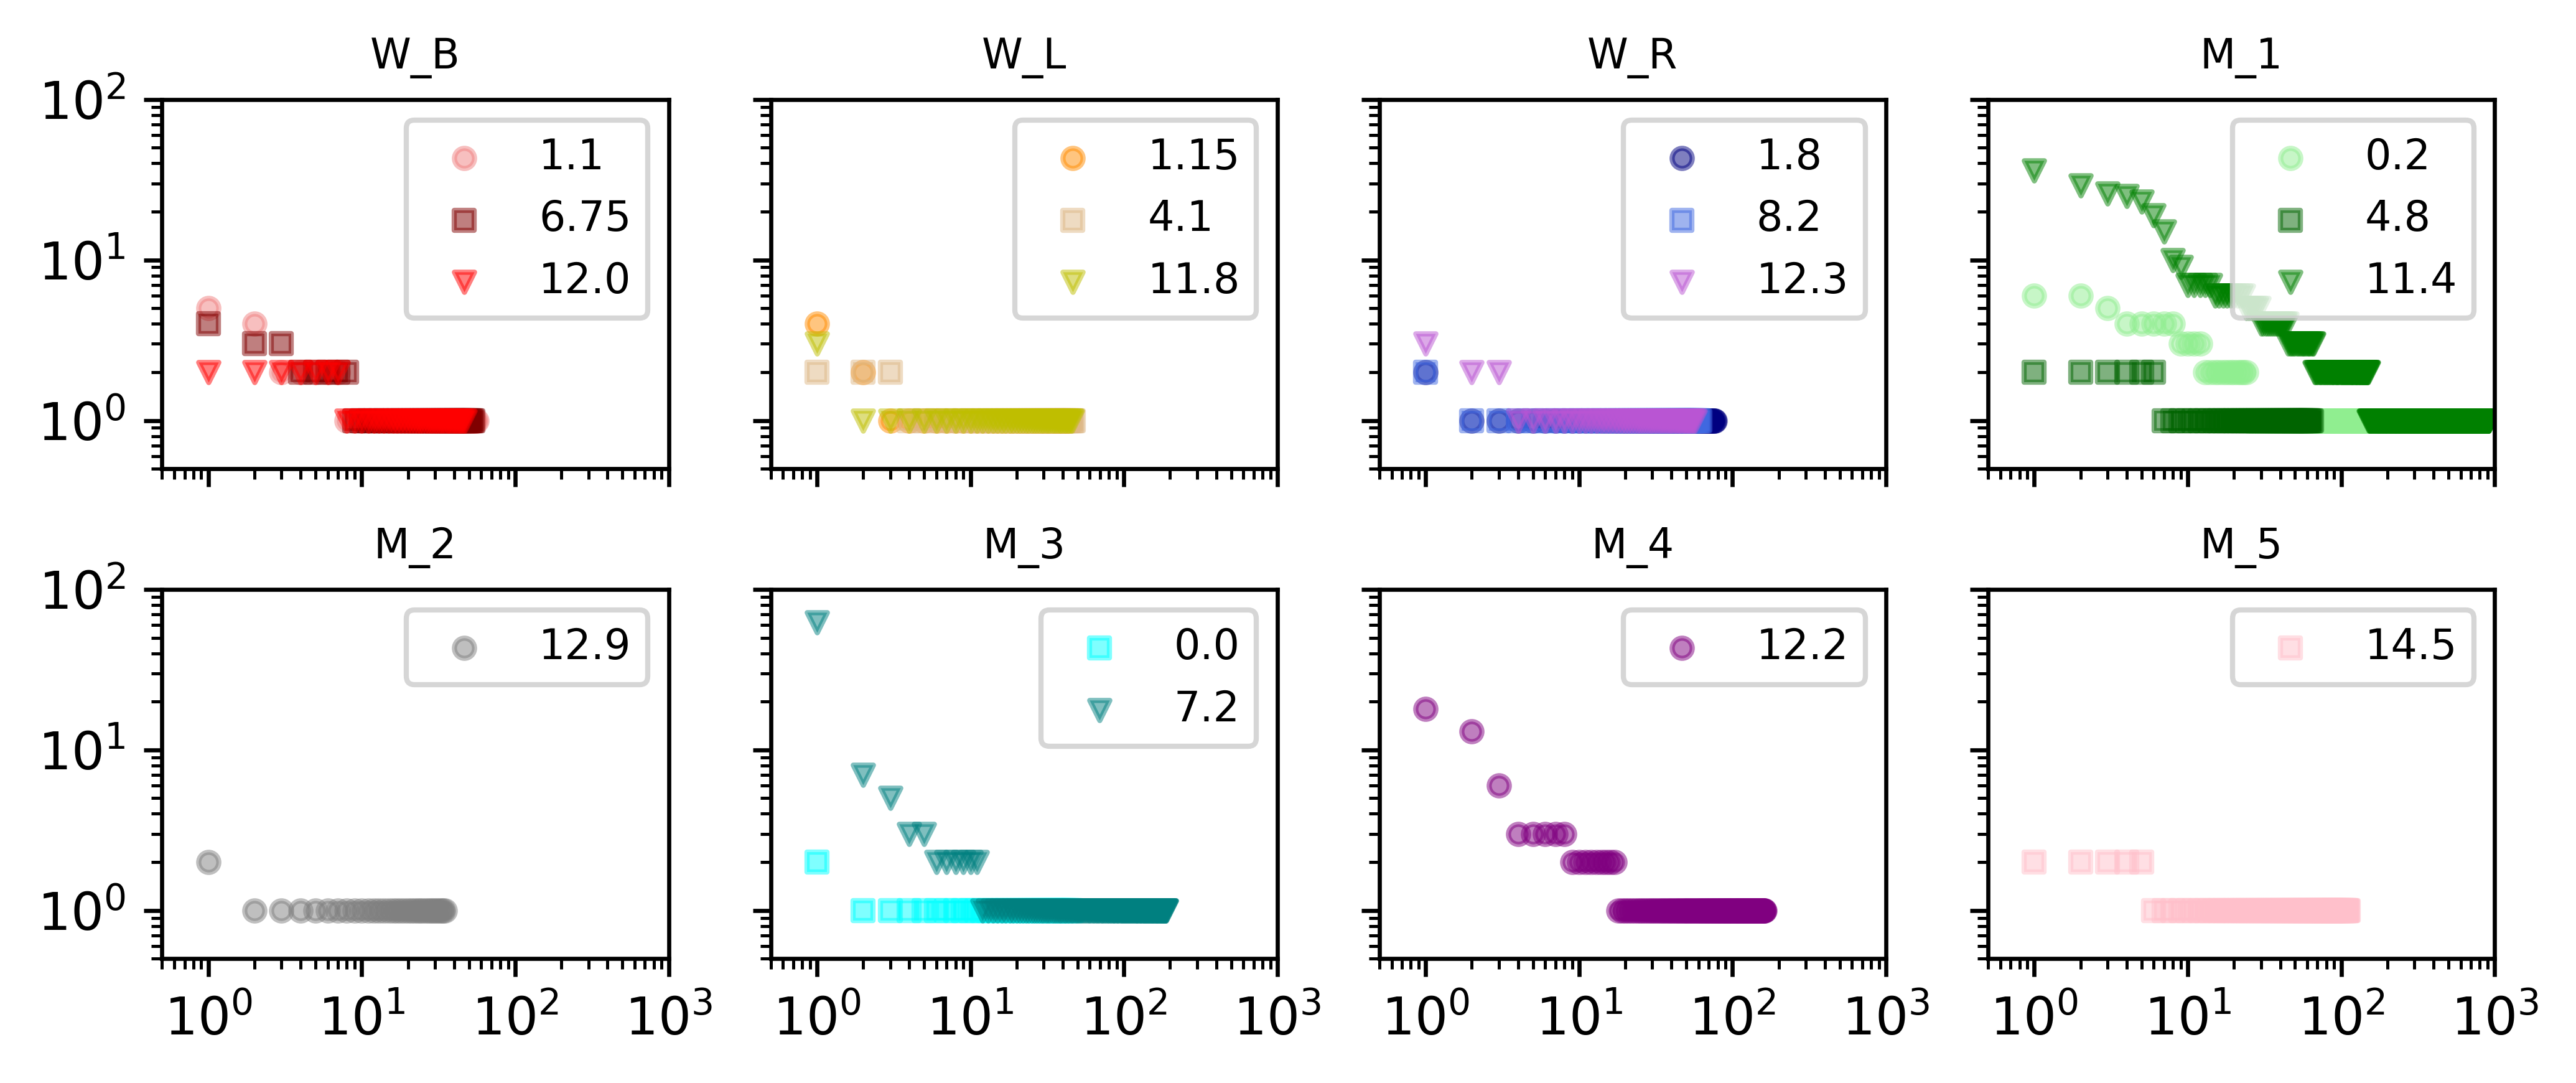

In [23]:
#rank abundance plots for each ppt
fig,axarr=plt.subplots(2,4,sharex=True,sharey=True,dpi=600,figsize=(7,3))
name=''
ppt_ind=-1
for i in range(len(obz)):

    if obz[i].name[2]!=name:
        pl_t=[[],[]]
        ppt_ind+=1
        name=obz[i].name[2]
        
    ax=axarr[int(ppt_ind/4)][ppt_ind%4]
    
    #plot and make legend
    ss=ax.scatter(obz[i].r,obz[i].a,color=obz[i].c,marker=obz[i].m,s=15,alpha=0.5)
    pl_t[0].append(ss)
    pl_t[1].append(obz[i].t)
    
    ax.loglog()
    ax.set_title(obz[i].name[:3],fontsize=8)
    ax.legend(pl_t[0],pl_t[1],fontsize=8,loc=1)
    
    
ax.set_xlim([0.5,1e3])
ax.set_ylim([5e-1,100])
plt.tight_layout()
plt.savefig('figures/WM_ra.pdf')

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:36: RuntimeWarning: invalid value encountered in double_scalars


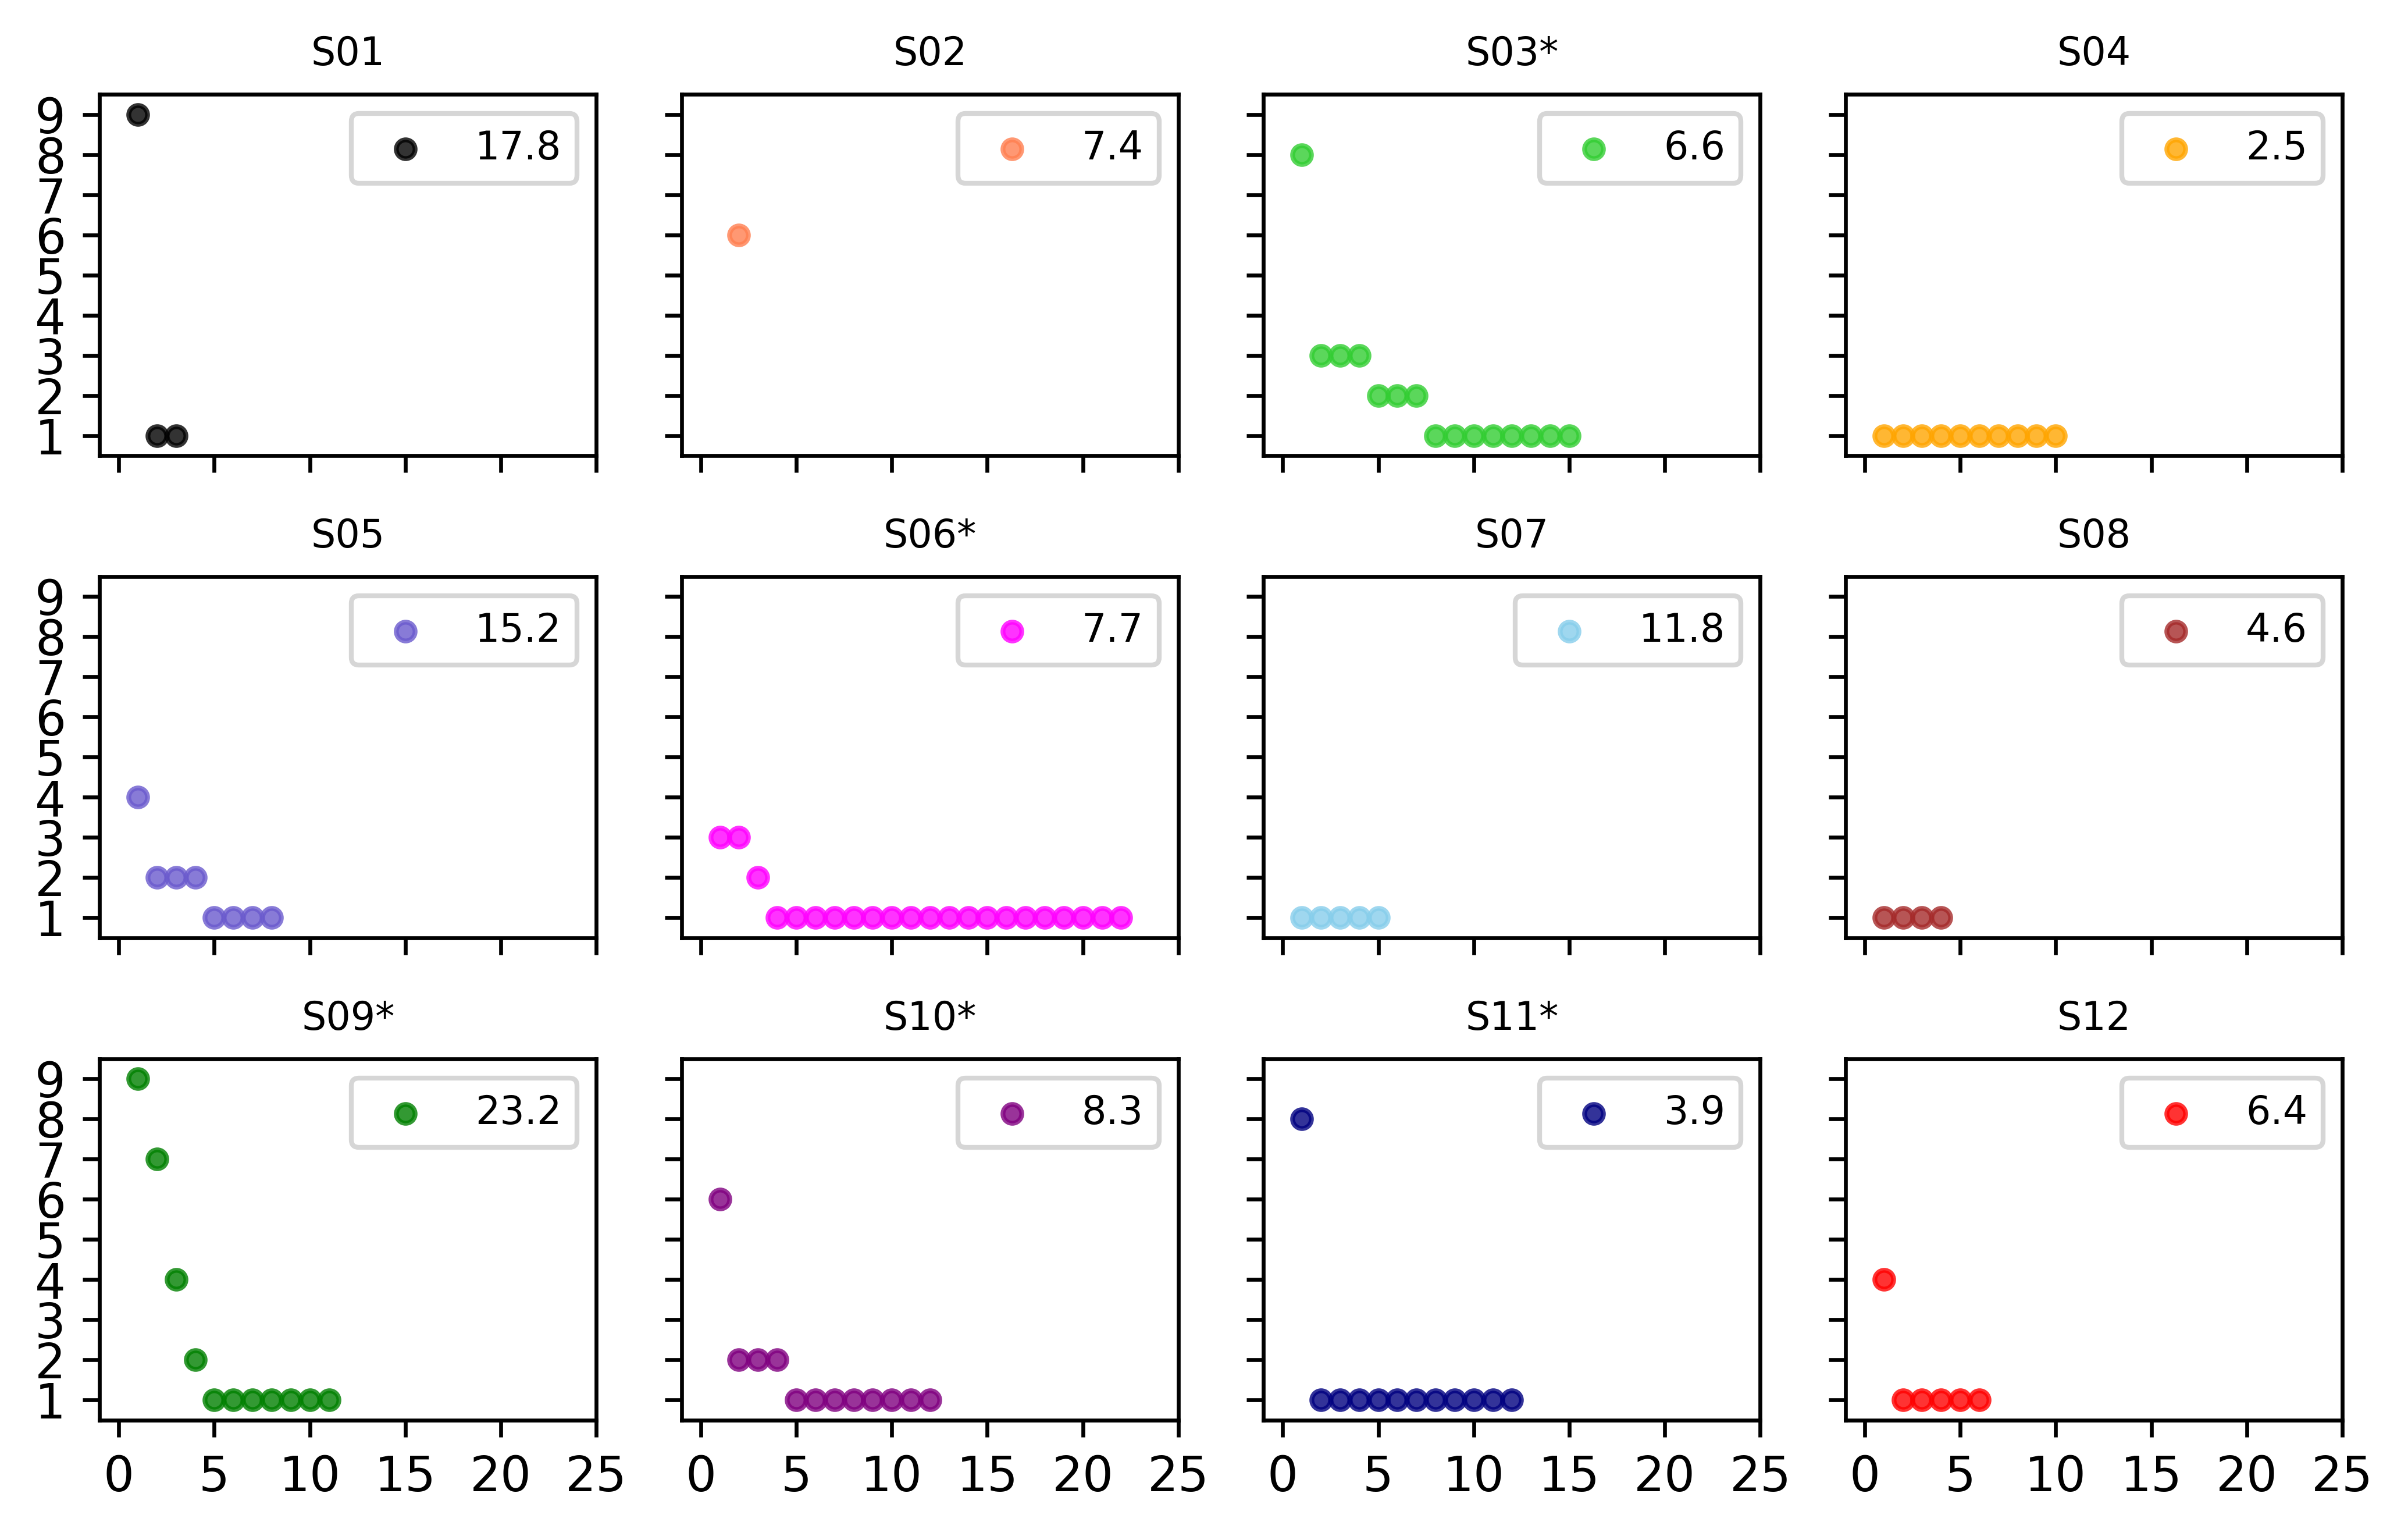

In [21]:
#rank abundance for Hosmane
S_ob=[] #list for objects

S01=[9,1,1]
S02=[6,11]
S03=[8,3,2,1,2,1,2,1,1,3,1,1,1,1,3]
S04=[1,1,1,1,1,1,1,1,1,1]
S05=[2,1,1,2,4,1,2,1]
S06=[3,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,3,1,1,1,1]
S07=[1,1,1,1,1]
S08=[1,1,1,1]
S09=[7,1,1,1,1,1,4,1,1,2,9]
S10=[6,1,1,1,1,2,2,1,1,2,1,1]
S11=[8,1,1,1,1,1,1,1,1,1,1,1]
S12=[4,1,1,1,1,1]

art_time=[17.8,7.4,6.6,2.5,15.2,7.7,11.8,4.6,23.2,8.3,3.9,6.4] #years of ART

S=[S01,S02,S03,S04,S05,S06,S07,S08,S09,S10,S11,S12] 
Snz=['S01','S02','S03','S04','S05','S06','S07','S08','S09','S10','S11','S12'] #names
Hcz=['black','coral','limegreen','orange','slateblue','magenta','skyblue','brown','green','purple','navy','red']

ok_list=[2,5,8,9,10] #list with number of samples>20

fig,axarr=plt.subplots(3,4,sharex=True,sharey=True,dpi=600,figsize=(7,4.5))
for i in range(len(S)):

    ax=axarr[int(i/4)][i%4]
    d=-np.sort(-np.array(S[i]))
    ob=site_set(Snz[i],art_time[i],d,Hcz[i],'o',i)
    S_ob.append(ob)
    
    ax.scatter(ob.r,ob.a,color=ob.c,marker=ob.m,s=15,alpha=0.8)
    ax.legend([str(ob.t)],fontsize=8)
    
    #ax.loglog()
    if i in ok_list:
        titz=Snz[i]+'*'
    else:
        titz=Snz[i]
    ax.set_title(titz,fontsize=8)

ax.set_xlim([-1,25])
ax.set_ylim([0.5,9.5])
ax.set_xticks(range(0,26,5))
#ax.set_xticklabels([0,5,10,15,20,25],fontsize=8)
ax.set_yticks(range(1,10))
plt.tight_layout()
plt.savefig('figures/H_ra.pdf')

        

In [11]:
#print some sentences about the data

num_clones=[]
frac_clones=[]
frac_cells_in_clones=[]
cells_in_clones=[]
cells_in_max_clone=[]
frac_in_max_clone=[]
for i in range(len(obz)):
    ob=obz[i]
    num_clones.append(sum(obz[i].Nx[2:]))
    frac_clones.append(sum(obz[i].Nx[2:])/sum(obz[i].Nx))
    
    NS=obz[i].Nx*np.arange(len(obz[i].Nx)) #number of cells N(n)*n
    cells_in_clones.append(sum(NS[2:])) #observed sequence clones
    frac_cells_in_clones.append(sum(NS[2:])/obz[i].N) #observed sequence clones
    cells_in_max_clone.append(NS[-1])
    frac_in_max_clone.append(NS[-1]/ob.N)
     
print('HIV DNA')
print('number of observed sequences that were clonal')
printer(num_clones)
print('fraction of observed sequences that were clonal')
printer(frac_clones)
print('number of cells observed in the largest clone')
printer(cells_in_max_clone)
print('fraction of cells observed in the largest clone')
printer(frac_in_max_clone)

num_clones=[]
frac_clones=[]
for i in range(len(S)):
            
    abund=S_ob[i].a
    ranks=S_ob[i].r
    
    num_clones.append(sum(abund>1)) #number of clonal types
    frac_clones.append(sum(abund>1)/sum(abund)) #fraction clonal of all types

print('REPLICATION COMPETENT (all)')
print('fraction of observed sequences that were clonal')
printer(frac_clones)

num_clones=[]
frac_clones=[]
frac_cells_in_clones=[]
cells_in_clones=[]
cells_in_max_clone=[]
frac_in_max_clone=[]
for i in range(len(ok_list)):
            
    abund=S_ob[ok_list[i]].a
    ranks=S_ob[ok_list[i]].r
    
    cells_in_max_clone.append(abund[0])
    frac_in_max_clone.append(abund[0]/sum(abund))
    
    num_clones.append(sum(abund>1)) #number of clonal types
    frac_clones.append(sum(abund>1)/sum(abund)) #fraction clonal of all types
    
print('REPLICATION COMPETENT (N>20)')
print('number of cells observed in the largest clone')
printer(cells_in_max_clone)
print('fraction of cells observed in the largest clone')
printer(frac_in_max_clone)
print('number of observed sequences that were clonal')
printer(num_clones)


HIV DNA
number of observed sequences that were clonal
1 - 150 mean:  14.5882352941
fraction of observed sequences that were clonal
0.012987012987 - 0.164113785558 mean:  0.0738302423335
number of cells observed in the largest clone
2 - 62 mean:  11.5882352941
fraction of cells observed in the largest clone
0.025641025641 - 0.259259259259 mean:  0.0884966513139
REPLICATION COMPETENT (all)
fraction of observed sequences that were clonal
0.0 - 0.285714285714 mean:  0.111071810226
REPLICATION COMPETENT (N>20)
number of cells observed in the largest clone
3 - 9 mean:  6.8
fraction of cells observed in the largest clone
0.111111111111 - 0.421052631579 mean:  0.280114617281
number of observed sequences that were clonal
1 - 7 mean:  3.8


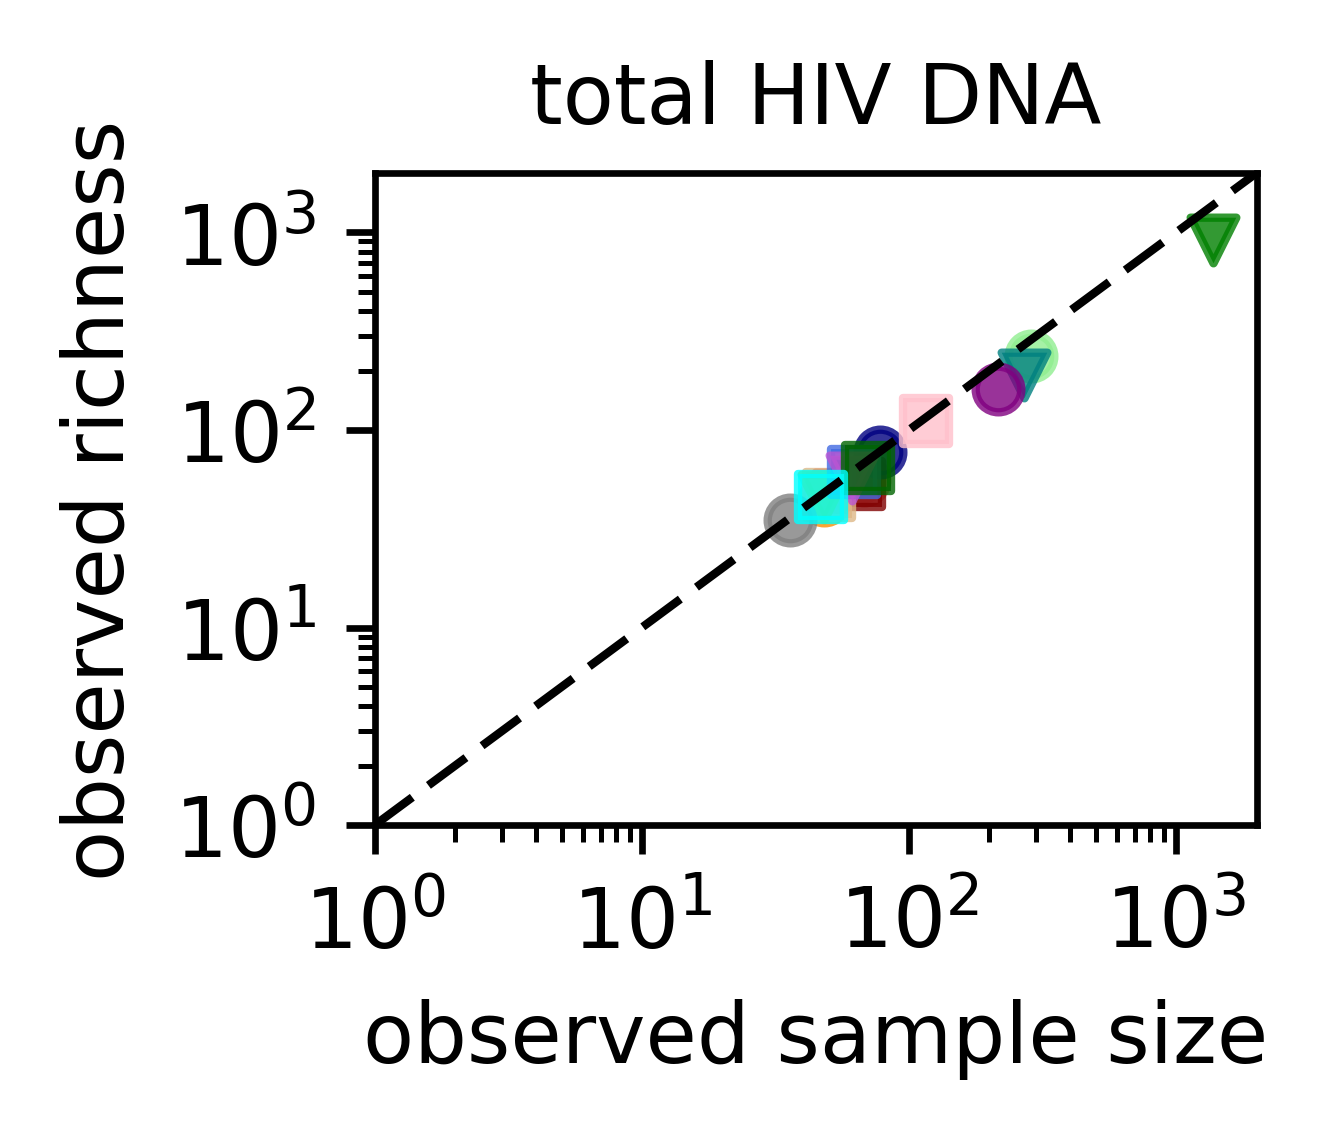

In [66]:
#plot “HIV sequence sample size (N)” (x-axis) versus “Number of distinct sequences (N(1)+2N(2)+3n(3)+….) (y-axis)

#samples plotted out, most have <50
plt.figure(figsize=(2.5,2),dpi=600)
for i in range(len(obz)):
    plt.scatter(obz[i].N,obz[i].Robs,color=obz[i].c,marker=obz[i].m,s=30,alpha=0.8)

plt.loglog(np.arange(1e4),np.arange(1e4),ls='--',color='k',lw=1)
plt.xlabel('observed sample size')
plt.ylabel('observed richness')
plt.ylim([1,2e3])
plt.xlim([1,2e3])
plt.xticks(np.logspace(0,3,4))
#plt.gca().set_xticks(ticks=np.logspace(0,3,4), minor=True)
plt.yticks(np.logspace(0,3,4))
plt.title('total HIV DNA',fontsize=10)

plt.tight_layout()
plt.savefig('figures/WM_NvR.pdf')

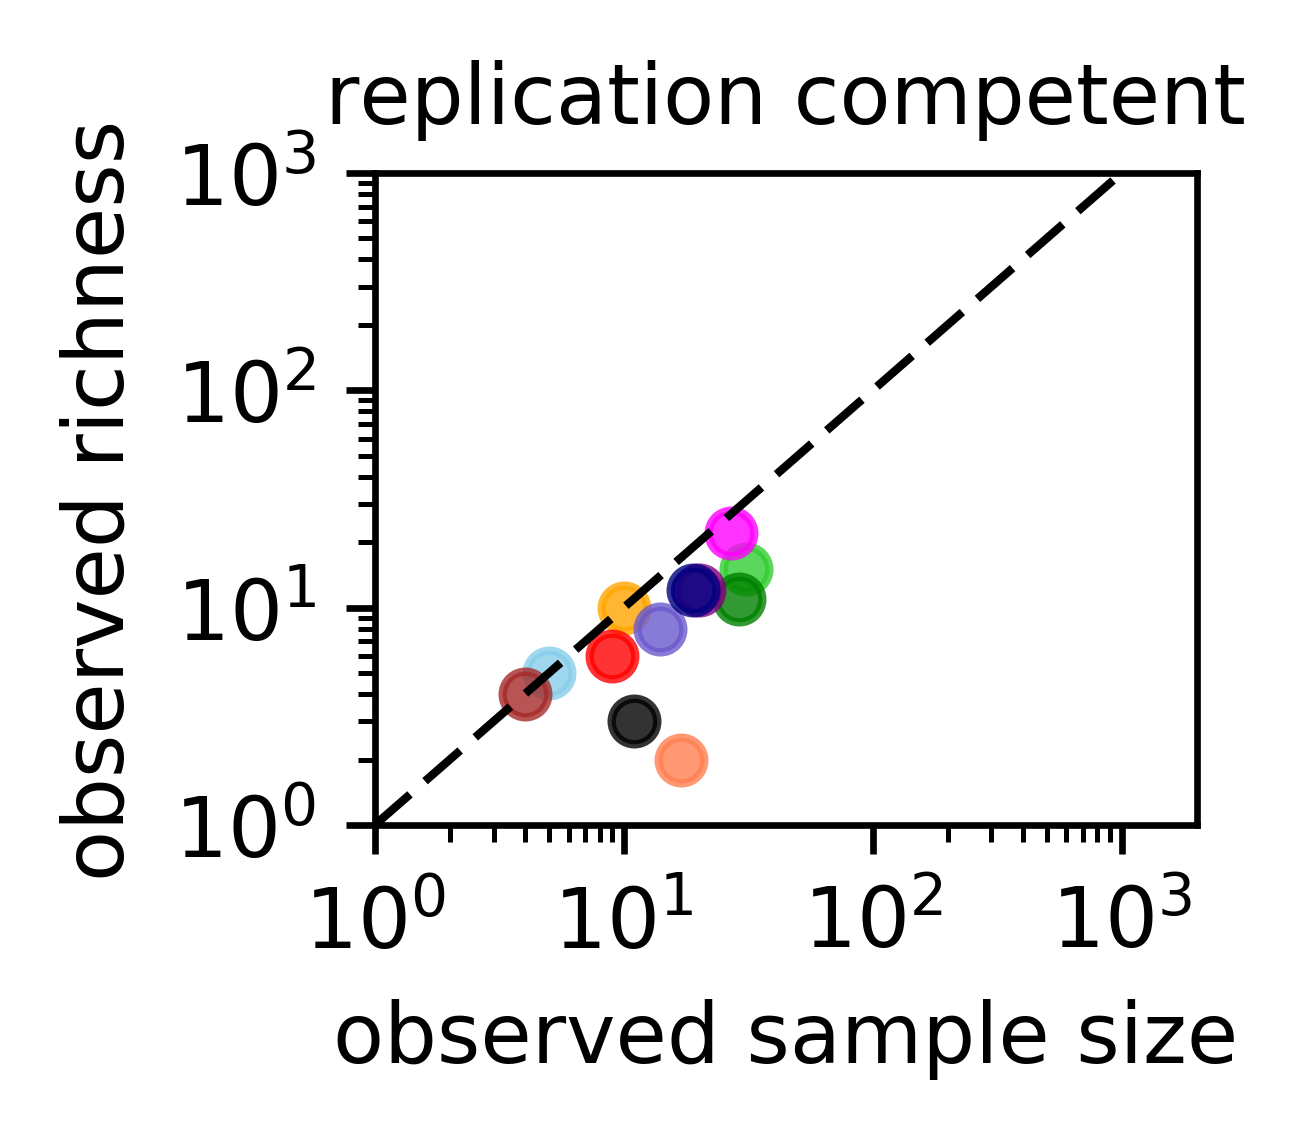

In [67]:
#plot HOSMANE “HIV sequence sample size (N)” (x-axis) versus “Number of distinct sequences (N(1)+2N(2)+3n(3)+….) (y-axis)

#samples plotted out, most have <50
plt.figure(figsize=(2.5,2),dpi=600)

for i in range(len(S)):
    plt.scatter(S_ob[i].N,S_ob[i].Robs,color=S_ob[i].c,s=30,alpha=0.8)

plt.loglog(np.arange(1e3),np.arange(1e3),ls='--',color='k',lw=1)
plt.xlabel('observed sample size')
plt.ylabel('observed richness')
plt.ylim([1,1e3])
plt.xlim([1,2e3])
plt.xticks(np.logspace(0,3,4))
plt.yticks(np.logspace(0,3,4))
plt.title('replication competent',fontsize=10)

plt.tight_layout()
plt.savefig('figures/H_NvR.pdf')

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


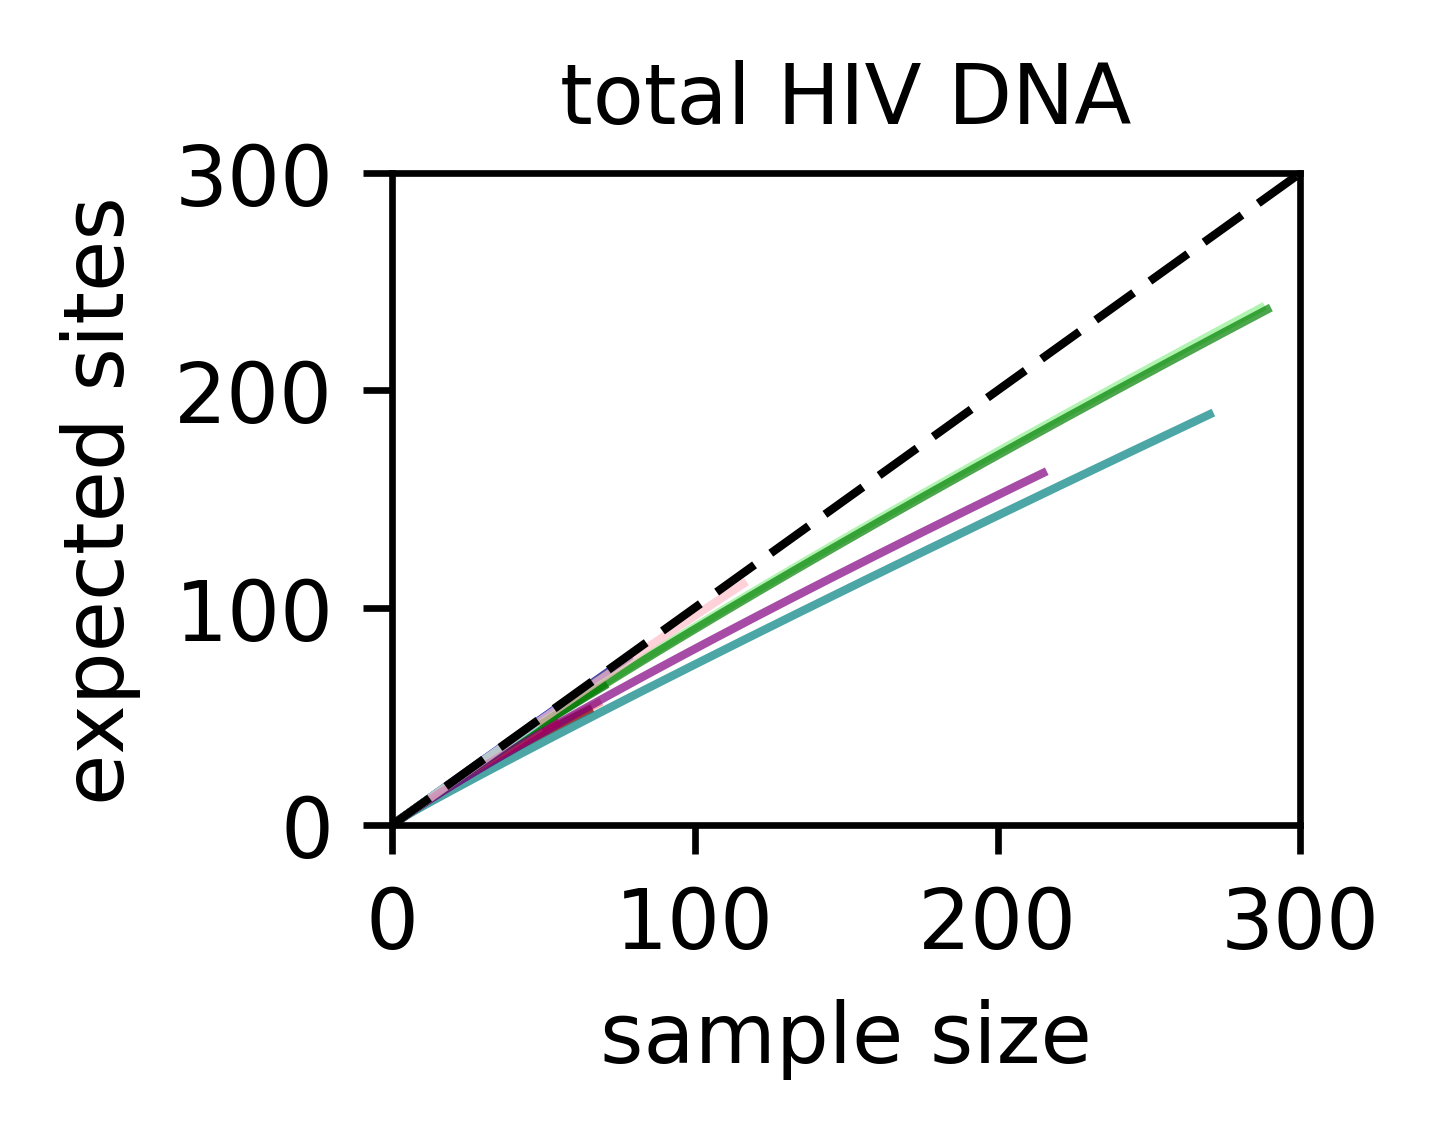

In [74]:
#observed rarefaction for W/M
plt.figure(figsize=(2.5,2),dpi=rez)
#compute each experimental rarefaction curve
for i in range(len(obz)):
    nkx,nky = rarefact(obz[i].a,ns=1000)#obz[i].N-max(obz[i].a))       
    plt.plot(nkx,nky,color=obz[i].c,lw=1,alpha=0.7)

plt.xlim([0,300])
plt.ylim([0,300])
plt.xticks(range(0,350,100))
plt.yticks(range(0,350,100))

plt.plot(np.arange(1e3),np.arange(1e3),ls='--',color='k',lw=1)
plt.xlabel('sample size')
plt.ylabel('expected sites')
plt.title('total HIV DNA',fontsize=10)

plt.tight_layout()
plt.savefig('figures/WM_rarefact.pdf')   


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars
/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


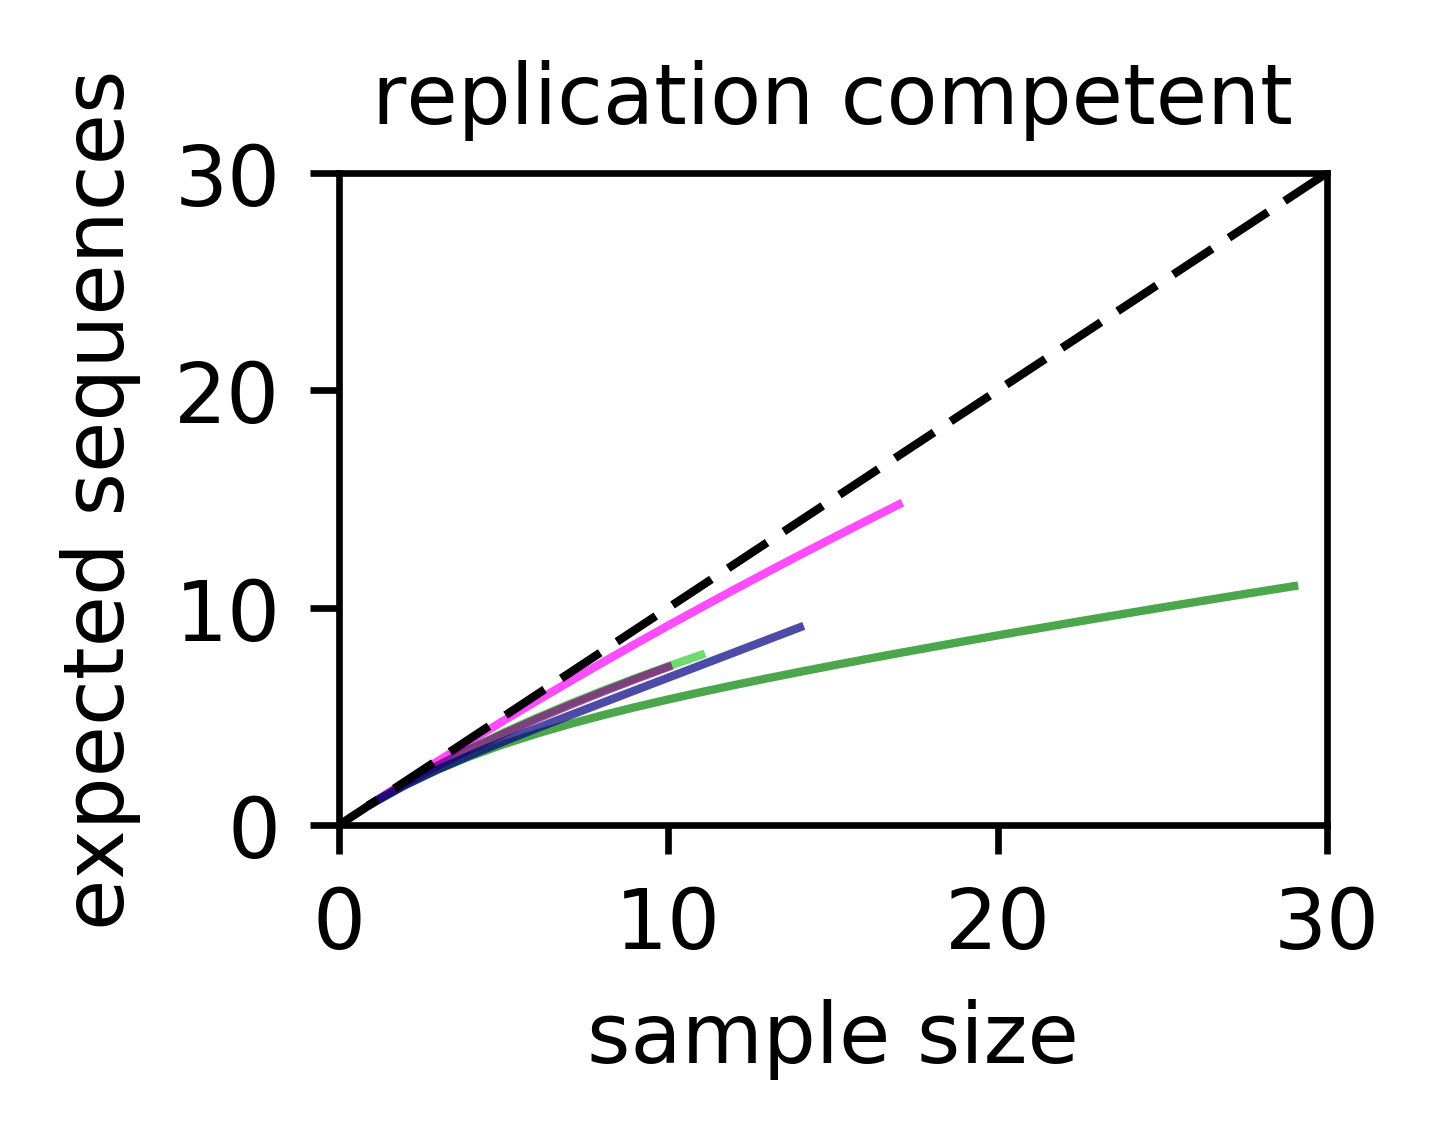

In [75]:
#observed rarefaction for HOSMANE
plt.figure(figsize=(2.5,2),dpi=rez)
#compute each experimental rarefaction curve
for i in range(len(ok_list)):    
    nkx,nky = rarefact(S_ob[ok_list[i]].a,ns=S_ob[i].N)       
    plt.plot(nkx,nky,color=S_ob[ok_list[i]].c,lw=1,alpha=0.7)
plt.xlim([0,30])
plt.ylim([0,30])
plt.xticks(range(0,35,10))
plt.yticks(range(0,35,10))
plt.plot(np.arange(1e3),np.arange(1e3),ls='--',color='k',lw=1)
plt.xlabel('sample size')
plt.ylabel('expected sequences')
plt.title('replication competent',fontsize=10)
plt.tight_layout()
plt.savefig('figures/H_rarefact.pdf')



0.907276470588 0.102647526714
1.40882 0.161476653421


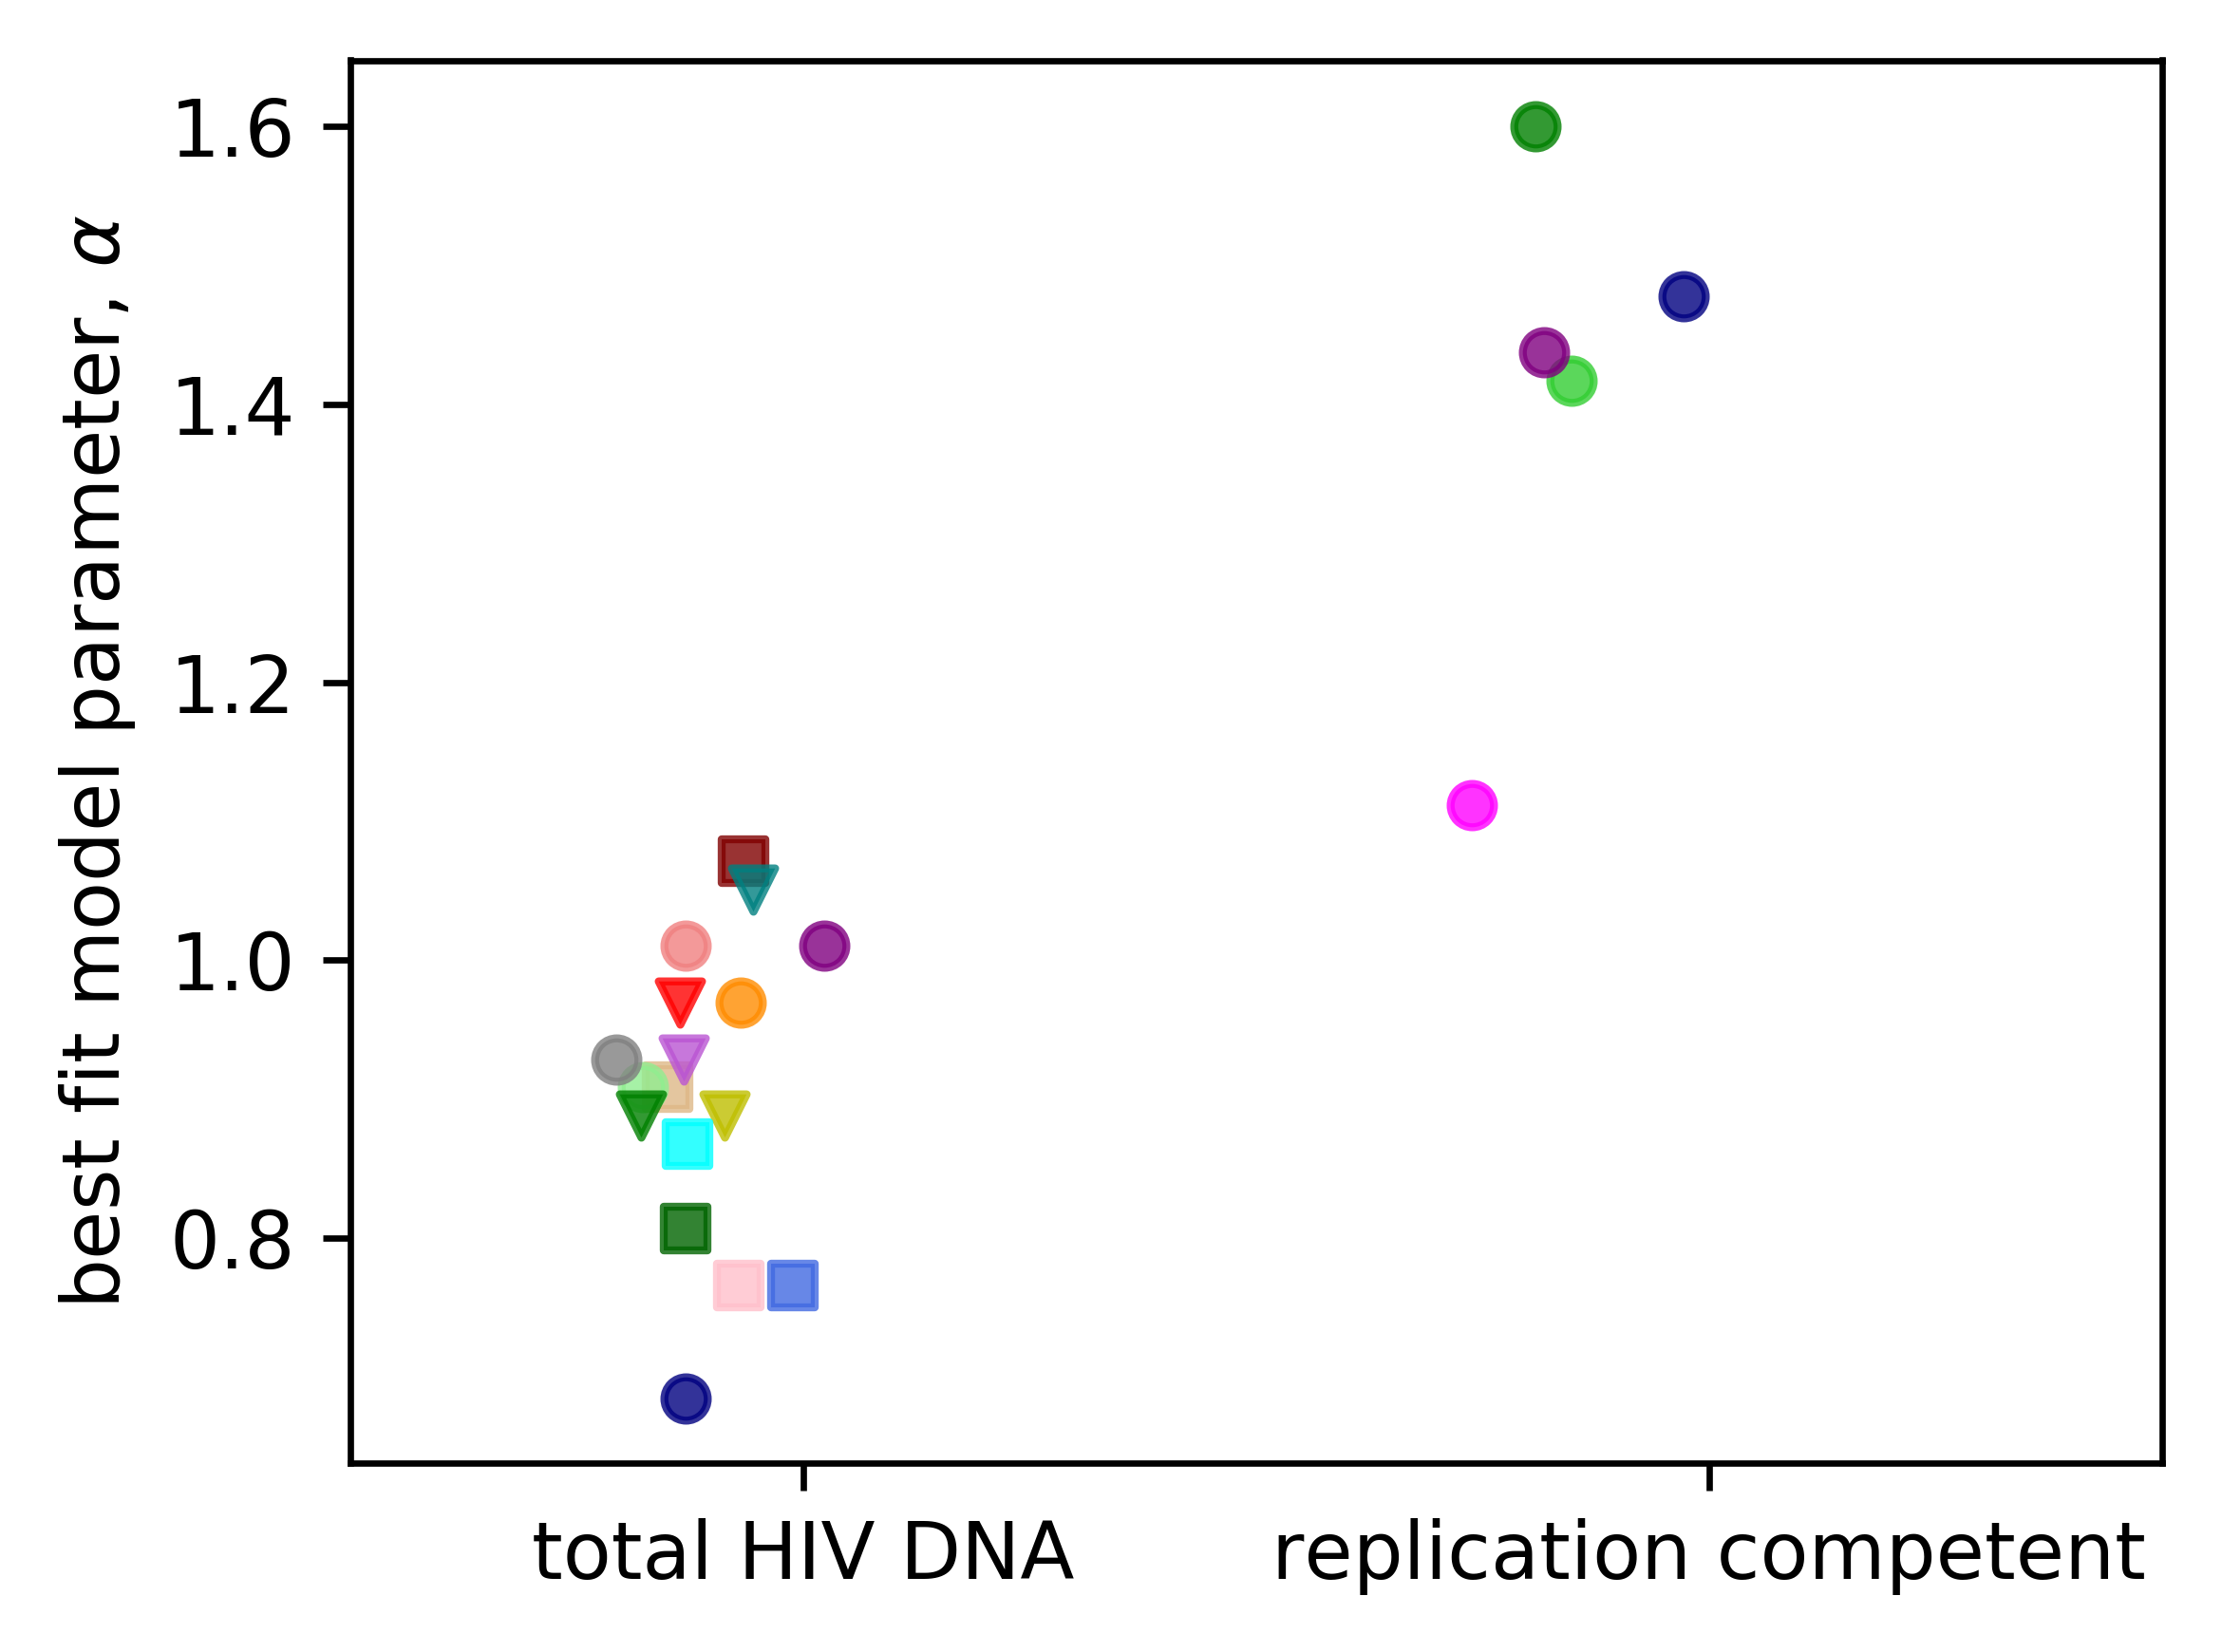

In [26]:
#showing max richness based on best fit alphas, pick the largest alpha out of the list of 5 best fits because that is monotonic with increasing richness

best_al_DNA=[
    1.0102,
    1.0712,
    0.9695,
    0.9695,
    0.9085,
    0.8881,
    0.6847,
    0.7661,
    0.9288,
    0.9085,
    0.8068,
    0.8881,
    0.9288,
    0.8678,
    1.0508,
    1.0102,
    0.7661]

print(np.mean(best_al_DNA),np.std(best_al_DNA))

best_al_Hos=[
    1.4169,
    1.1119,
    1.6000,
    1.4373,
    1.4780]

print(np.mean(best_al_Hos),np.std(best_al_Hos))

plt.figure(figsize=(4,3),dpi=600)
for i in range(len(obz)):
    al=best_al_DNA[i]
    ob=obz[i]
    plt.scatter(np.random.normal(1,0.05),best_al_DNA[i],color=ob.c,marker=ob.m,s=30,alpha=0.8)

for i in range(len(ok_list)):    
    plt.scatter(np.random.normal(2,0.05),best_al_Hos[i],color=Hcz[ok_list[i]],s=30,alpha=0.8)

#plt.boxplot([best_al_DNA,best_al_Hos])
plt.xlim([0.6,2.6])
plt.xticks([1.1,2.1],['total HIV DNA','replication competent'])
plt.ylabel(r'best fit model parameter, $\alpha$')
plt.tight_layout()
plt.savefig('figures/alphas.pdf')

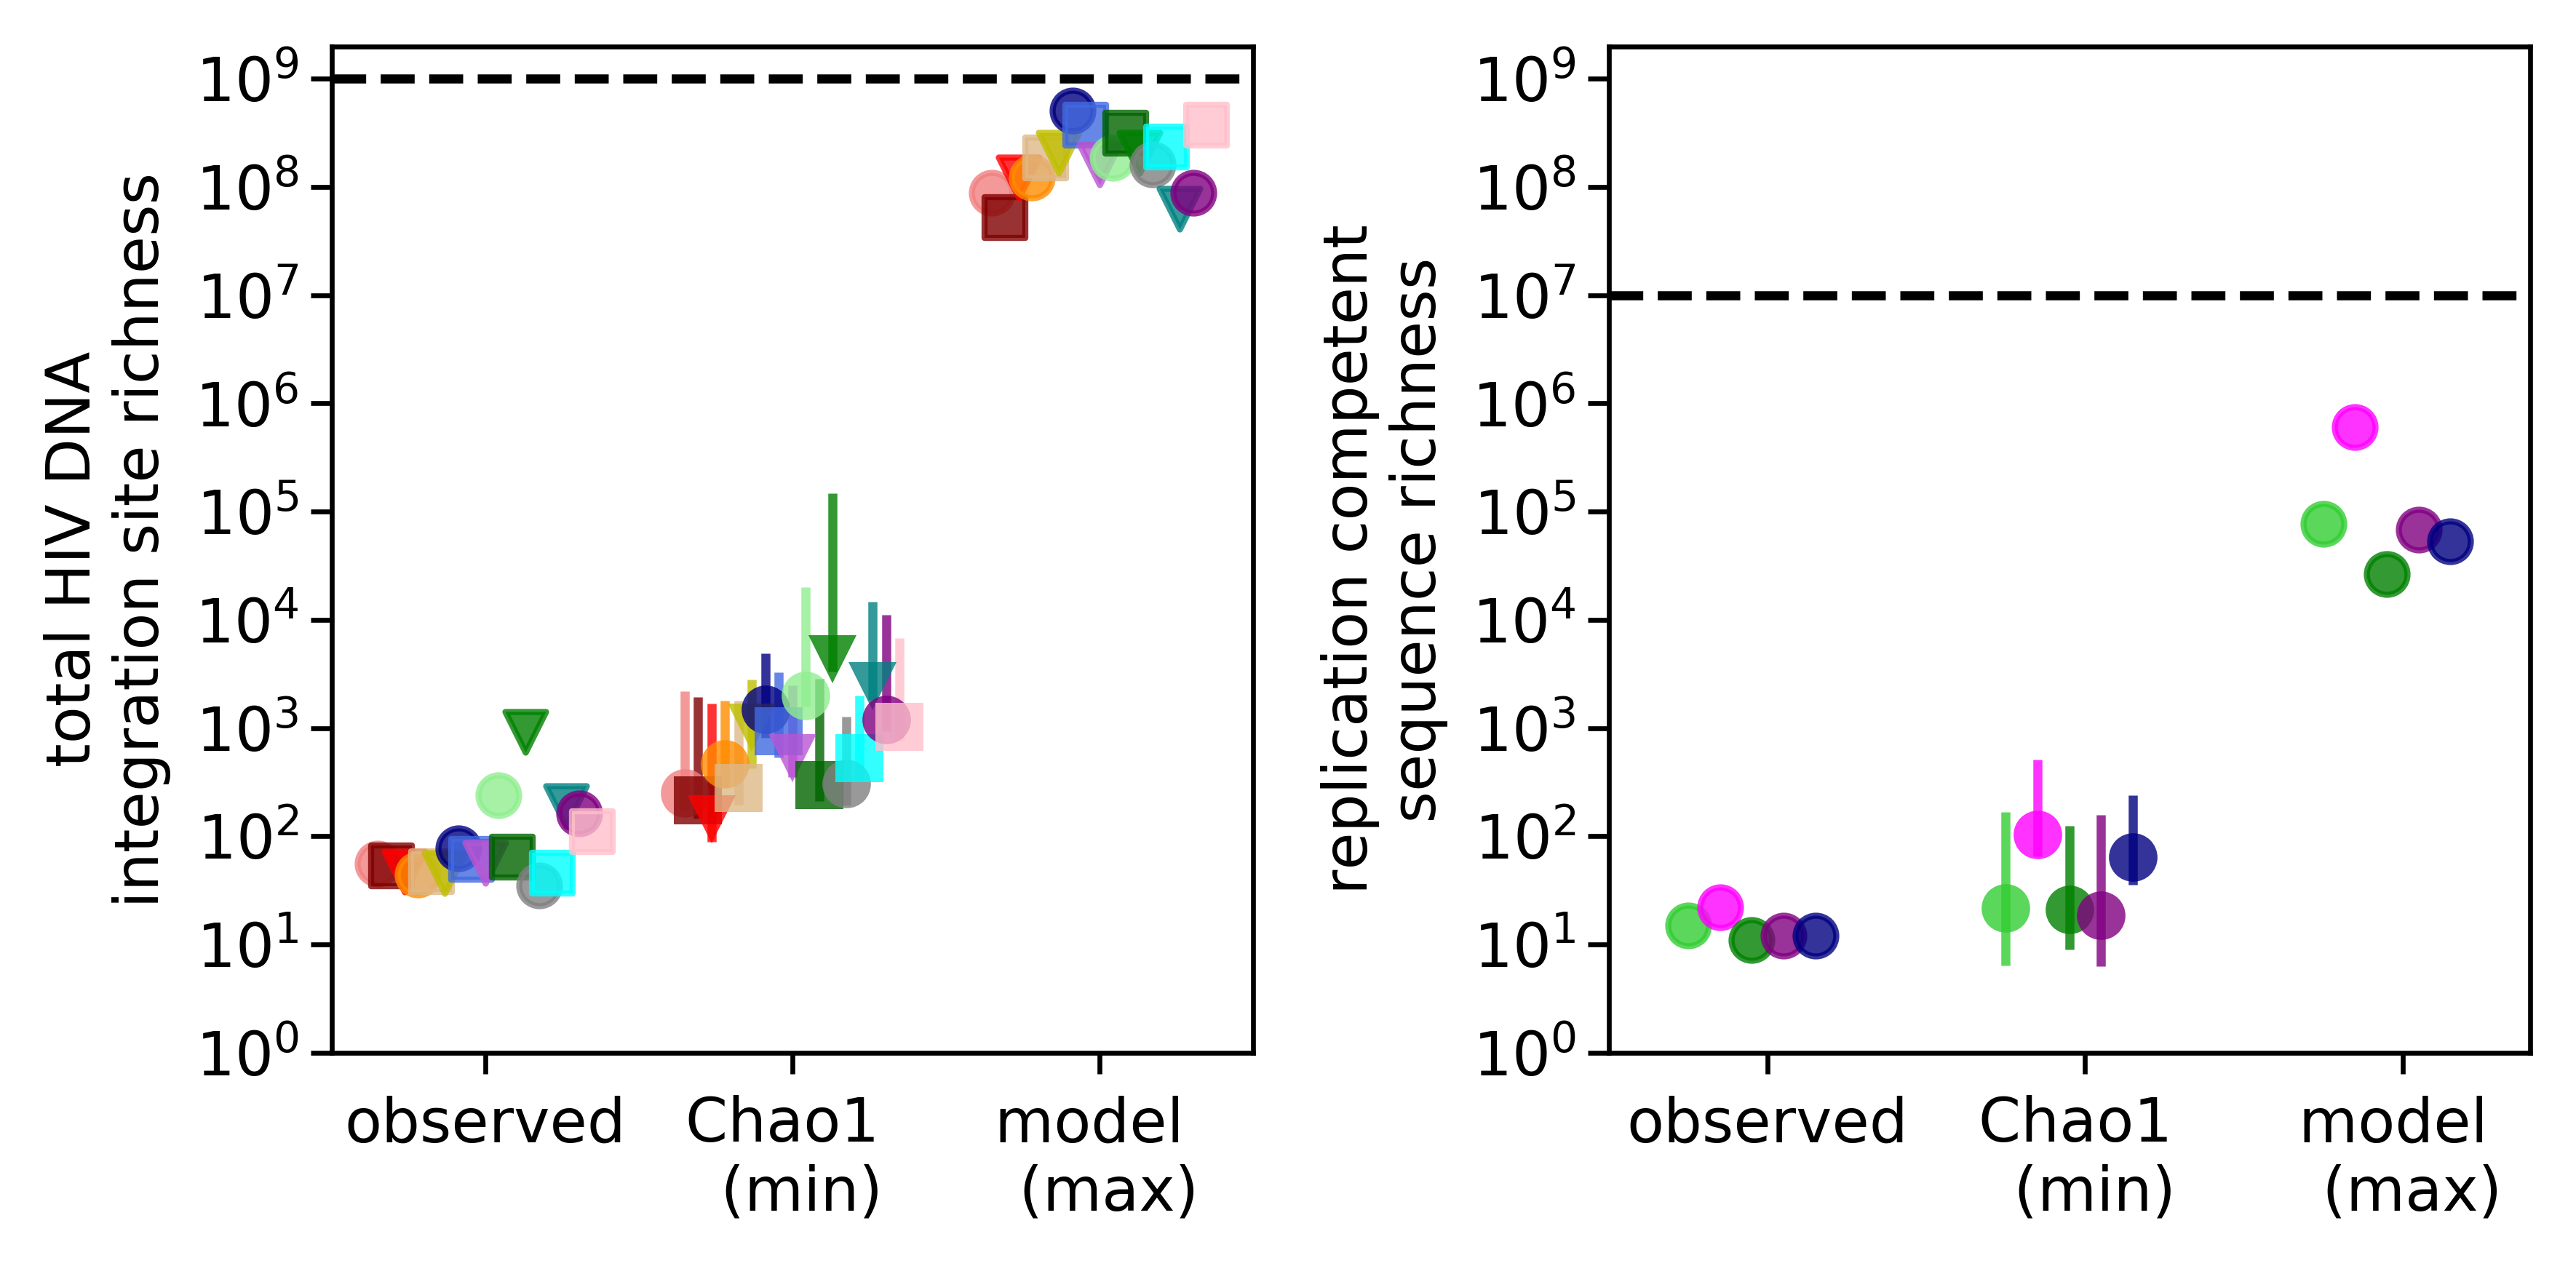

In [100]:
#compare richness estimates

#plot richness and estimates all as boxplots
plt.figure(figsize=(6,3),dpi=rez)

#lists for richness estimates
RlWM=[[],[],[]]; RWM=1e9; LWM=1e9
RlH=[[],[],[]]; RH=1e7; LH=1e7

jit=0.15 #for scatter jitter

x1f=np.linspace(-0.35,0.35,len(obz))
plt.subplot(121)
for i in range(len(obz)):

    #set up x axis locations for each scatter point    
    x1=1+x1f[i]; 
    x2=2+x1f[i]; 
    x3=3+x1f[i]; 
    
    plt.scatter(x1,obz[i].Robs,color=obz[i].c,marker=obz[i].m,s=45,alpha=0.8)
    plt.errorbar(x2,obz[i].Rchao,obz[i].CI,color=obz[i].c,marker=obz[i].m,alpha=0.8,
                markeredgewidth=0,markersize=8)
    
    al=best_al_DNA[i]    
    psi=0.5*(1-RWM**(1-al))/(LWM*(al-1));
    mr=np.exp(np.log(psi)/-al); #approximate max richness
    if mr>RWM:
        mr=RWM
    plt.scatter(x3,mr,color=obz[i].c,marker=obz[i].m,alpha=0.8,s=45)

    #for box plots
    RlWM[0].append(obz[i].Robs)
    RlWM[1].append(obz[i].Rchao)
    RlWM[2].append(mr)

#plt.boxplot(RlWM)
plt.ylabel('total HIV DNA \n integration site richness') 
plt.yscale('log')  
plt.xticks([1,2,3],['observed','Chao1 \n (min)','model \n (max)'])
plt.xlim([0.5,3.5])
plt.ylim([1,2e9])
plt.axhline(LWM,color='k',ls='--')
plt.yticks(np.logspace(0,9,10),[])
plt.gca().set_yticks(np.logspace(0,9,10),minor=True)

plt.subplot(122)
for i in range(len(ok_list)): 
    
    #set up x axis locations for each scatter point
    x1=3/4+i/2/len(ok_list)
    x2=1+3/4+i/2/len(ok_list)
    x3=2+3/4+i/2/len(ok_list)
    
    plt.scatter(x1,S_ob[ok_list[i]].Robs,color=S_ob[ok_list[i]].c,s=45,alpha=0.8)
    plt.errorbar(x2,S_ob[ok_list[i]].Rchao,S_ob[ok_list[i]].CI,
                 color=S_ob[ok_list[i]].c,marker=S_ob[ok_list[i]].m,alpha=0.8,
                markeredgewidth=0,markersize=8)
   
    al=best_al_Hos[i]
    psi=0.5*(1-RH**(1-al))/(LH*(al-1));
    mr=np.exp(np.log(psi)/-al); #approximate max richness
    if mr>RH:
        mr=RH
    plt.scatter(x3,mr,color=S_ob[ok_list[i]].c,s=45,alpha=0.8)

    #for box plots
    RlH[0].append(S_ob[ok_list[i]].Robs)
    RlH[1].append(S_ob[ok_list[i]].Rchao)
    RlH[2].append(mr)

#plt.boxplot(RlH)
plt.ylabel('replication competent \n sequence richness') 
plt.yscale('log')
plt.xlim([1/2,3.4])
plt.xticks([1,2,3],['observed','Chao1 \n (min)','model \n (max)'])
plt.ylim([1,2e9])
plt.axhline(LH,color='k',ls='--')
plt.yticks(np.logspace(0,9,10),[])
plt.gca().set_yticks(np.logspace(0,9,10),minor=True)

plt.tight_layout()
plt.savefig('figures/richness.eps')


7.00006896049
7.00314055293
6.99999596104
7.00005163454
7.00002662144


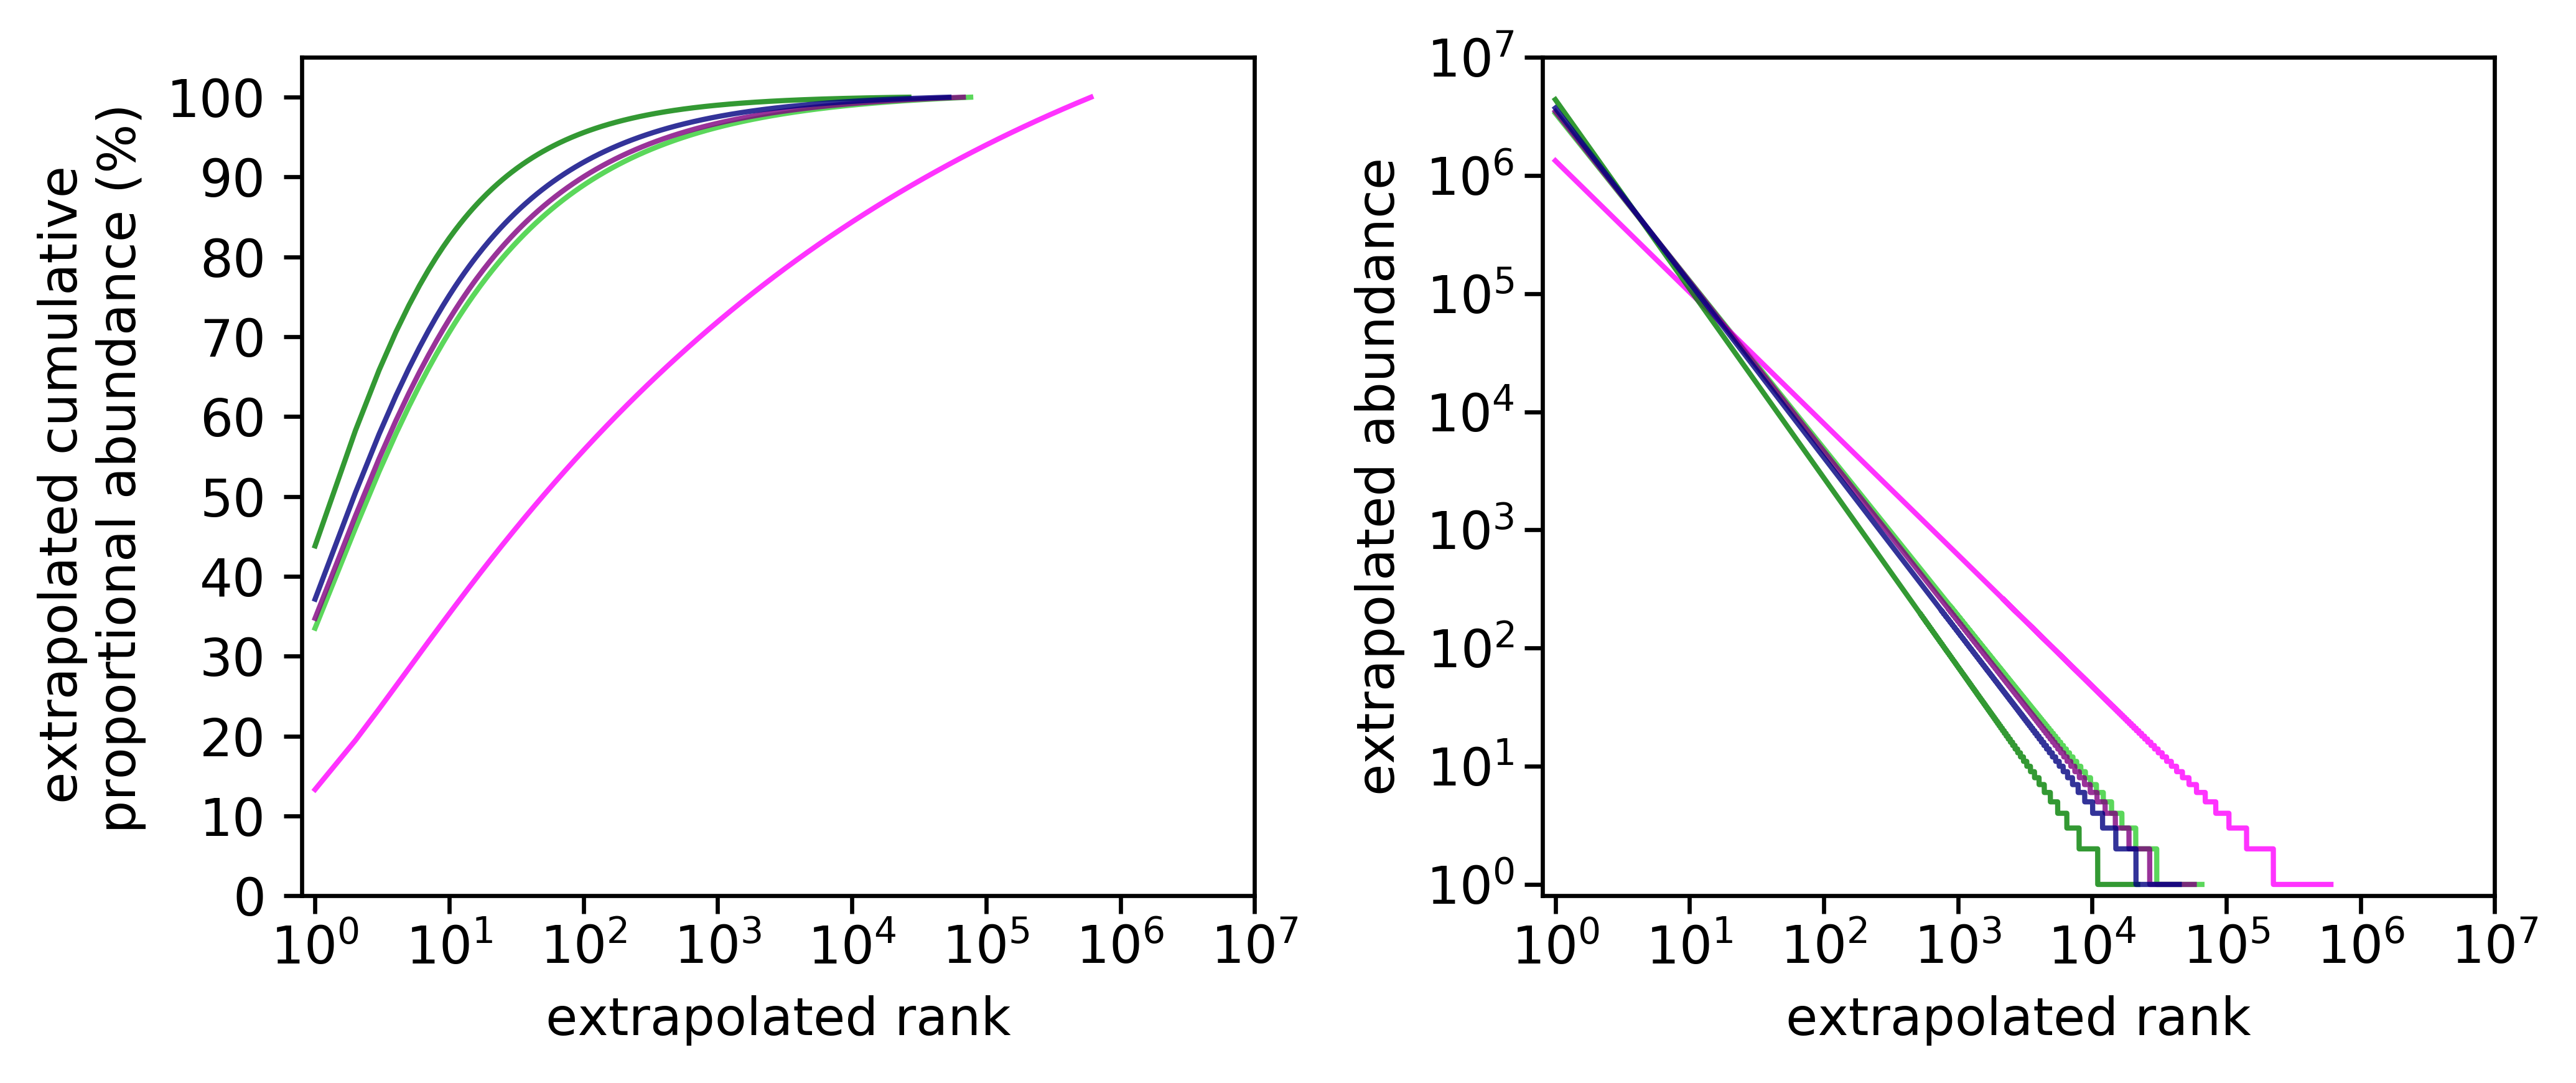

In [107]:
#extrapolate Hosmane
plt.figure(figsize=(7,3),dpi=600)

for i in range(len(ok_list)):    
    al=best_al_Hos[i]
    mr=RlH[2][i]

    r=np.arange(1,mr+1)
    a=r**(-al)
    pa=a/sum(a)
    cpa=np.cumsum(pa)
    a=np.round(LH*pa)
    print(np.log10(sum(a)))
    
    plt.subplot(121)
    plt.semilogx(r,cpa*100,color=Hcz[ok_list[i]],alpha=0.8,lw=1)

    plt.subplot(122)
    plt.loglog(r,a,color=Hcz[ok_list[i]],alpha=0.8,lw=1)


plt.subplot(121)
plt.xlabel('extrapolated rank')
plt.xticks(np.logspace(0,7,8),[])
plt.gca().set_xticks(np.logspace(0,7,8),minor=True)
plt.ylabel('extrapolated cumulative \n proportional abundance (%)')
plt.yticks(np.linspace(0,100,11))
plt.xlim([0.8,1e7])
plt.ylim([0,105])

plt.subplot(122)
plt.xlabel('extrapolated rank')
plt.xticks(np.logspace(0,7,8),[])
plt.gca().set_xticks(np.logspace(0,7,8),minor=True)
plt.ylabel('extrapolated abundance')
plt.ylim([0.8,1e7])
plt.xlim([0.8,1e7])
plt.yticks(np.logspace(0,7,8),[])
plt.gca().set_yticks(np.logspace(0,7,8),minor=True)

plt.tight_layout()
plt.savefig('figures/Hextrap.pdf')   

0
1
2
3
4


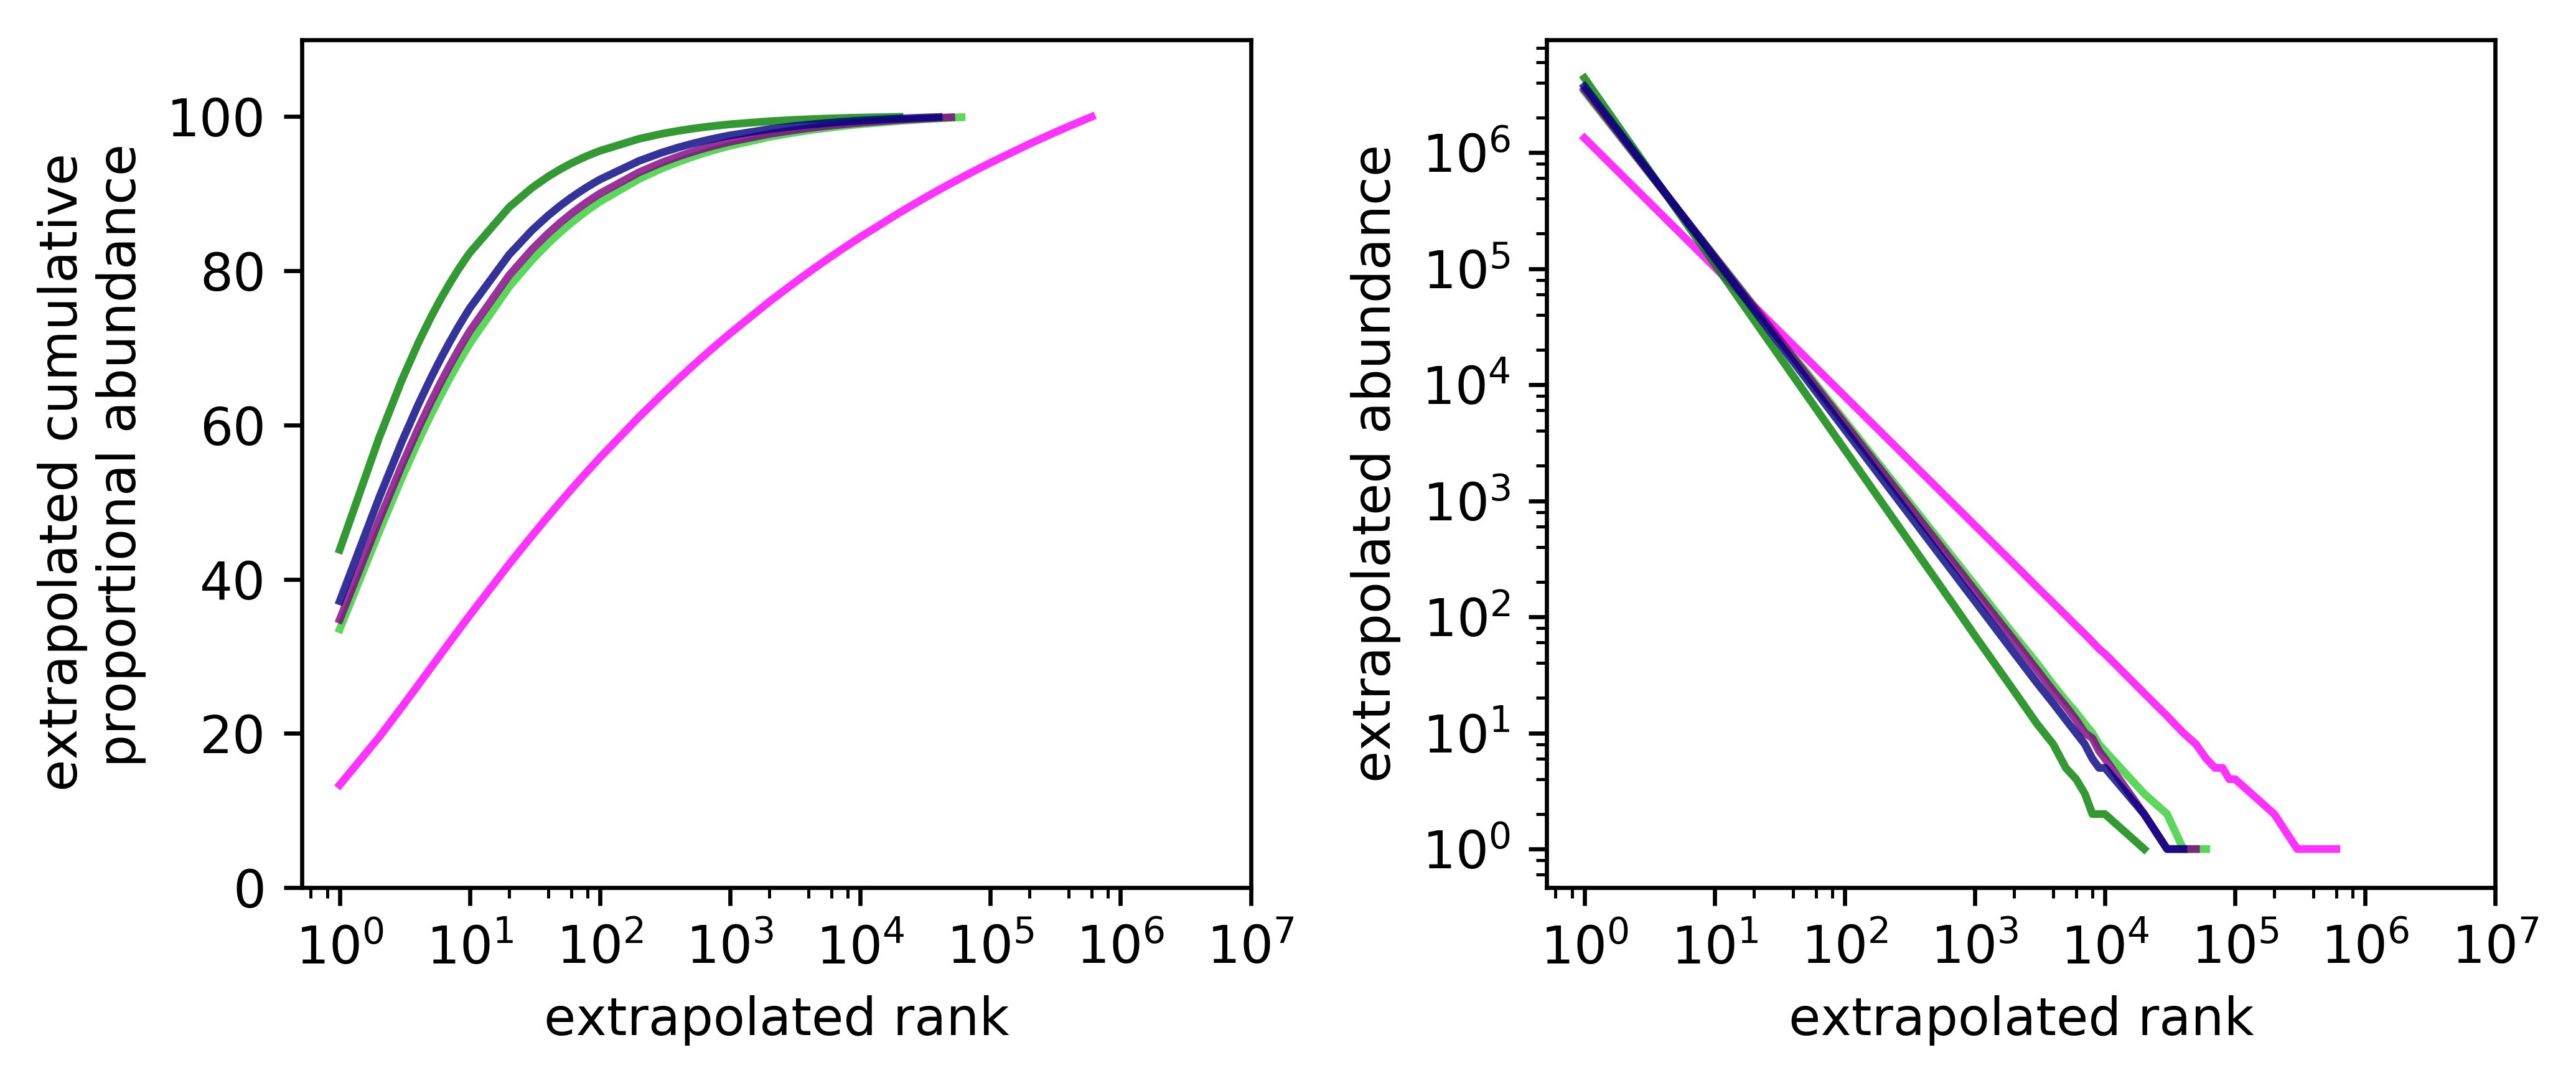

In [82]:
#extrapolate Hosmane LOOP (to check with above)
plt.figure(figsize=(7,3),dpi=600)

for i in range(len(ok_list)):    
    al=best_al_Hos[i]
    mr=RlH[2][i]
        
    #truly logarithmic list for ranks 1,2,...10,20,...,100,200,... etc
    r_ds=np.ndarray.flatten(np.tile(np.arange(1,10),[9,1])*np.transpose(np.tile(10**np.arange(0,9),[9,1])))    
    a_ds=np.zeros(len(r_ds)) #abundance downsampled
    c_ds=np.zeros(len(r_ds)) #cumulative abundance downsampled
    
    #loop over ranks, don't have to store them all
    sumz=0
    ds_int=0
    for r in np.arange(1.,mr+1.):
        a=r**(-al)
        sumz+=a
        
        #if goes past the next ds point, add to lists
        if r>r_ds[ds_int]-1:
            a_ds[ds_int]=a
            c_ds[ds_int]=sumz
            ds_int+=1
            
    pa_ds=a_ds/sumz
    
    a_ex=np.round(pa_ds*LH)
    
    plt.subplot(122)
    plt.loglog(r_ds[a_ex>0],a_ex[a_ex>0],color=Hcz[ok_list[i]],alpha=0.8)

    plt.subplot(121)
    plt.semilogx(r_ds[a_ex>0],c_ds[a_ex>0]/sumz*100.,color=Hcz[ok_list[i]],alpha=0.8)

    print(i)
plt.subplot(121)
plt.xlabel('extrapolated rank')
plt.ylabel('extrapolated cumulative \n proportional abundance')
#plt.grid('on')
plt.xticks(np.logspace(0,7,8))
plt.ylim([0,110])

plt.subplot(122)
plt.xlabel('extrapolated rank')
plt.ylabel('extrapolated abundance')
plt.xticks(np.logspace(0,7,8))

plt.tight_layout()
plt.savefig('figures/Hextrap-looptest.pdf')   

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


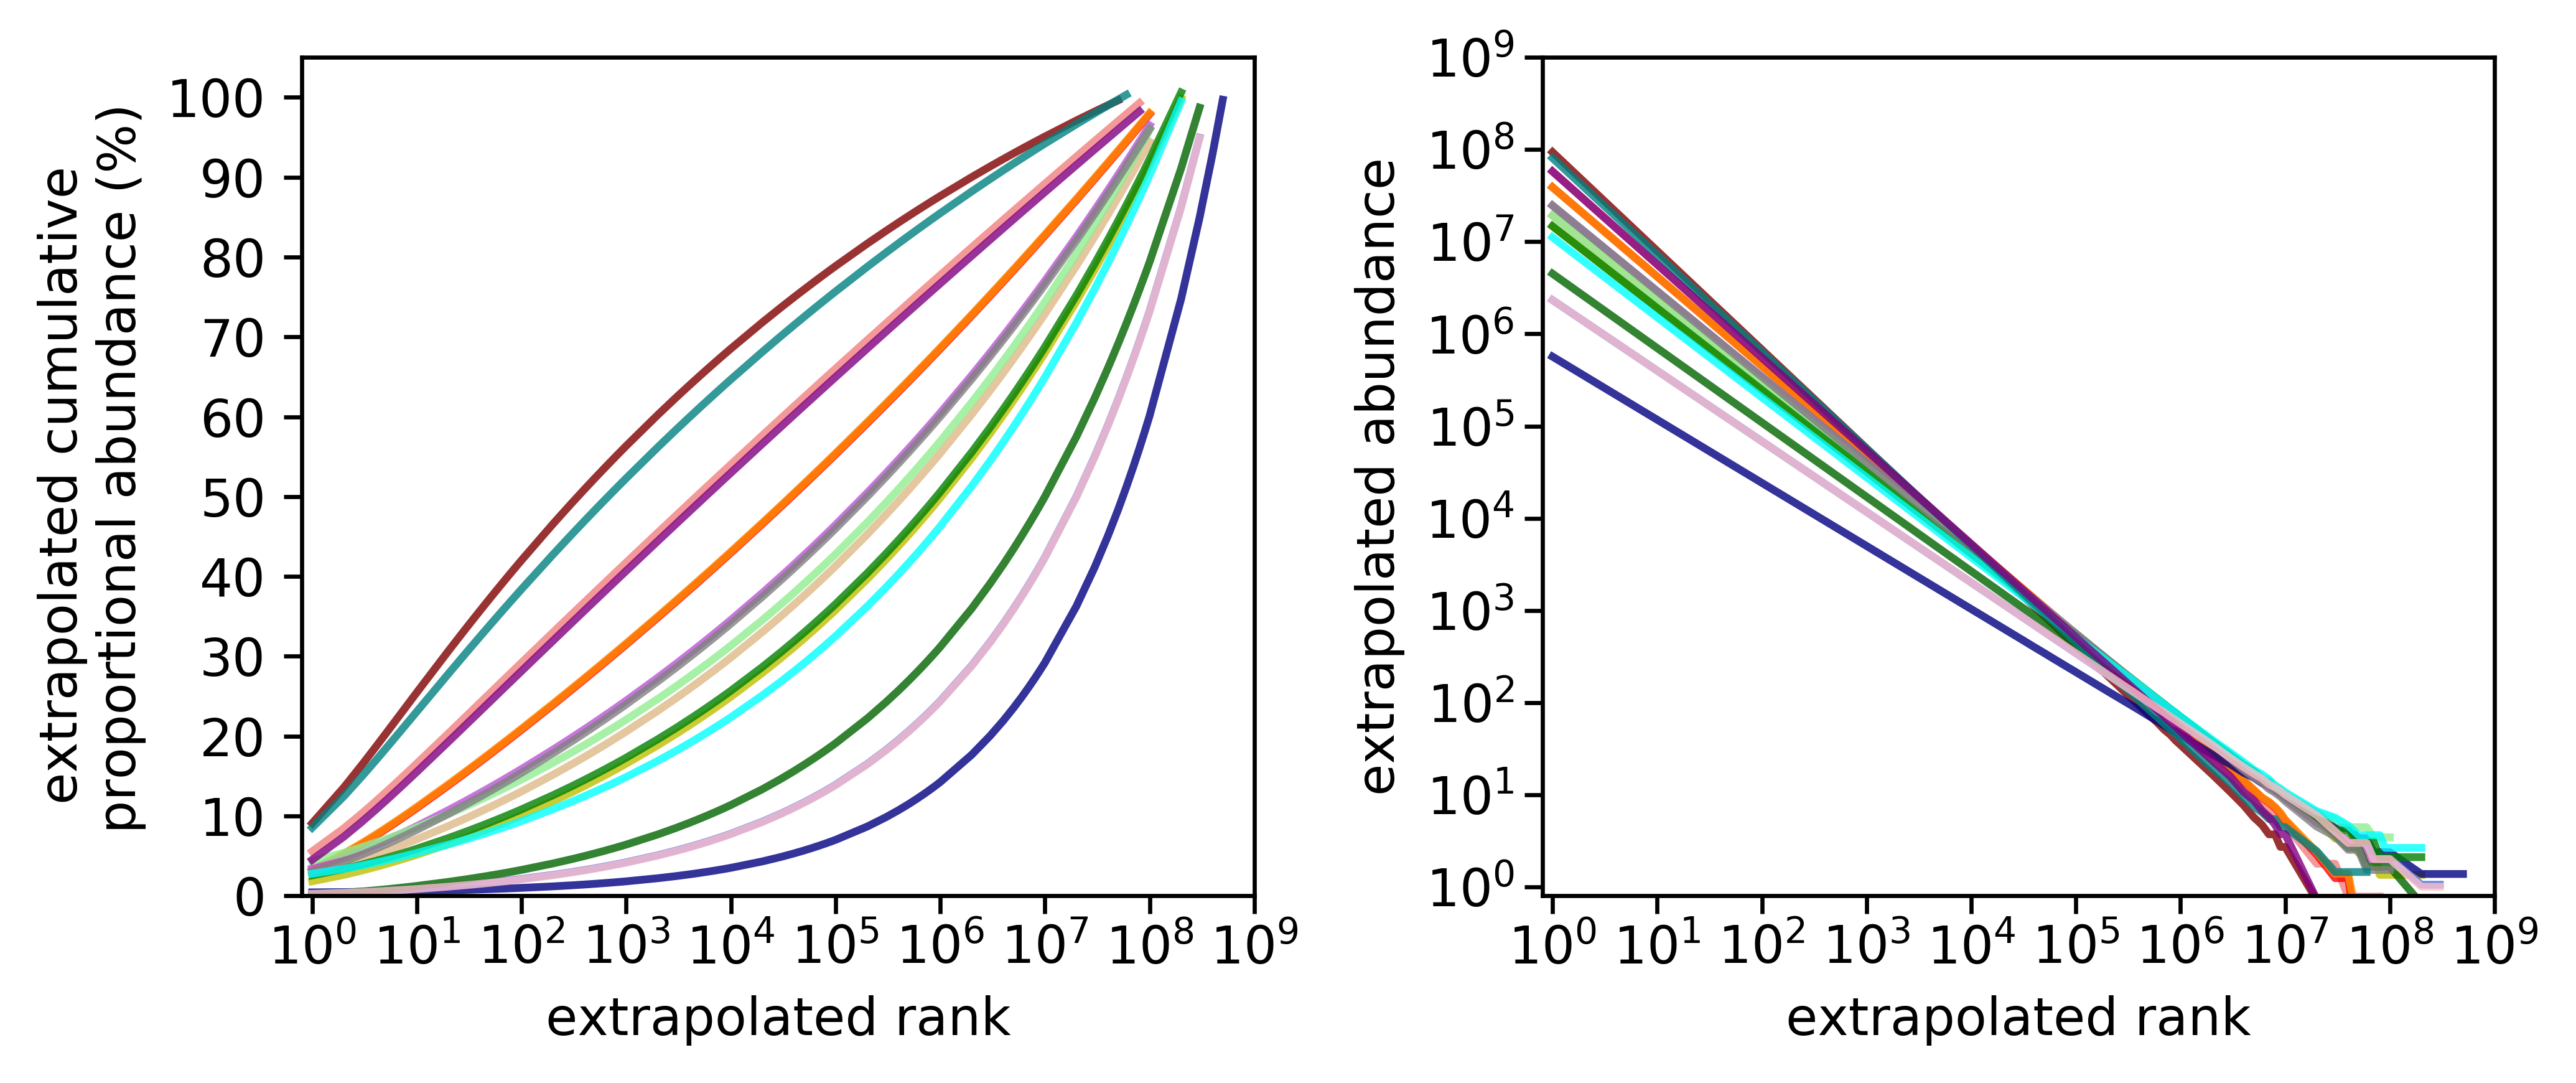

In [109]:
#extrapolate total DNA reservoir LOOP (need to loop it to do it in a reasonable time, still slow tho)
plt.figure(figsize=(7,3),dpi=600)

for i in range(len(obz)):
    al=best_al_DNA[i]
    mr=RlWM[2][i]
        
    #truly logarithmic list for ranks 1,2,...10,20,...,100,200,... etc
    r_ds=np.ndarray.flatten(np.tile(np.arange(1,10),[9,1])*np.transpose(np.tile(10**np.arange(0,9),[9,1])))    
    a_ds=np.zeros(len(r_ds)) #abundance downsampled
    c_ds=np.zeros(len(r_ds)) #cumulative abundance downsampled
    
    #loop over ranks, don't have to store them all
    sumz=0
    ds_int=0
    for r in np.arange(1.,mr+1.):
        a=r**(-al)
        sumz+=a
        
        #if goes past the next ds point, add to lists
        if r>r_ds[ds_int]-1:
            a_ds[ds_int]=a
            c_ds[ds_int]=sumz
            ds_int+=1
            
    pa_ds=a_ds/sumz
    a_ex=np.round(pa_ds*LWM) #the whole reservoir
    
    rxx=np.random.normal(0,1) #random shift so not plotted on top of ecahother
    
    plt.subplot(121)
    plt.semilogx(r_ds[a_ex>0],c_ds[a_ex>0]/sumz*100+rxx,color=obz[i].c,alpha=0.8)

    plt.subplot(122)
    plt.loglog(r_ds[a_ex>0],a_ex[a_ex>0]+rxx,color=obz[i].c,alpha=0.8)

    print(i)
    
plt.subplot(121)
plt.xlabel('extrapolated rank')
plt.xticks(np.logspace(0,9,10),[])
plt.gca().set_xticks(np.logspace(0,9,10),minor=True)
plt.xlim([0.8,1e9])
plt.ylabel('extrapolated cumulative \n proportional abundance (%)')
plt.yticks(np.linspace(0,100,11))
plt.ylim([0,105])

plt.subplot(122)
plt.xlabel('extrapolated rank')
plt.xticks(np.logspace(0,9,10),[])
plt.gca().set_xticks(np.logspace(0,9,10),minor=True)
plt.xlim([0.8,1e9])
plt.ylabel('extrapolated abundance')
plt.yticks(np.logspace(0,9,10),[])
plt.gca().set_yticks(np.logspace(0,9,10),minor=True)
plt.ylim([0.8,1e9])

plt.tight_layout()
plt.savefig('figures/WMextrap.pdf')   

In [31]:
#compute approximation rarefaction curve based on rank and abundance data for Hosmane
al=np.mean(best_al_Hos)
mr=np.mean(RlH[2])
    
rs=np.arange(1,mr)
ab=rs**(-al)
ab=ab/sum(ab)
ab=np.round(ab*LH)
ab=ab[ab>0]

R_real=len(ab)
L_real=sum(ab)

num_samples=10000 #for rarefaction

cH=range(1,num_samples+1) #cells counted
fH=np.zeros(num_samples) #found distinct
for c in cH:
    fH[c-1]=R_real-np.sum((1-ab/L_real)**c)

#do approximation rarefaction curve based on rank and abundance data for DNA
al=np.mean(best_al_DNA)
mr=1e6#np.mean(RlWM[2]) #can maybe use a smaller number, doesn't matter for sample size

rs=np.arange(1,mr)
ab=rs**(-al)
ab=ab/sum(ab)
ab=np.round(ab*LWM)
ab=ab[ab>0]

R_real=len(ab)
L_real=sum(ab)

fD=np.zeros(num_samples) #found distinct
cD=range(1,num_samples+1) #cells counted
for c in cD:
    fD[c-1]=R_real-np.sum((1-ab/L_real)**c)

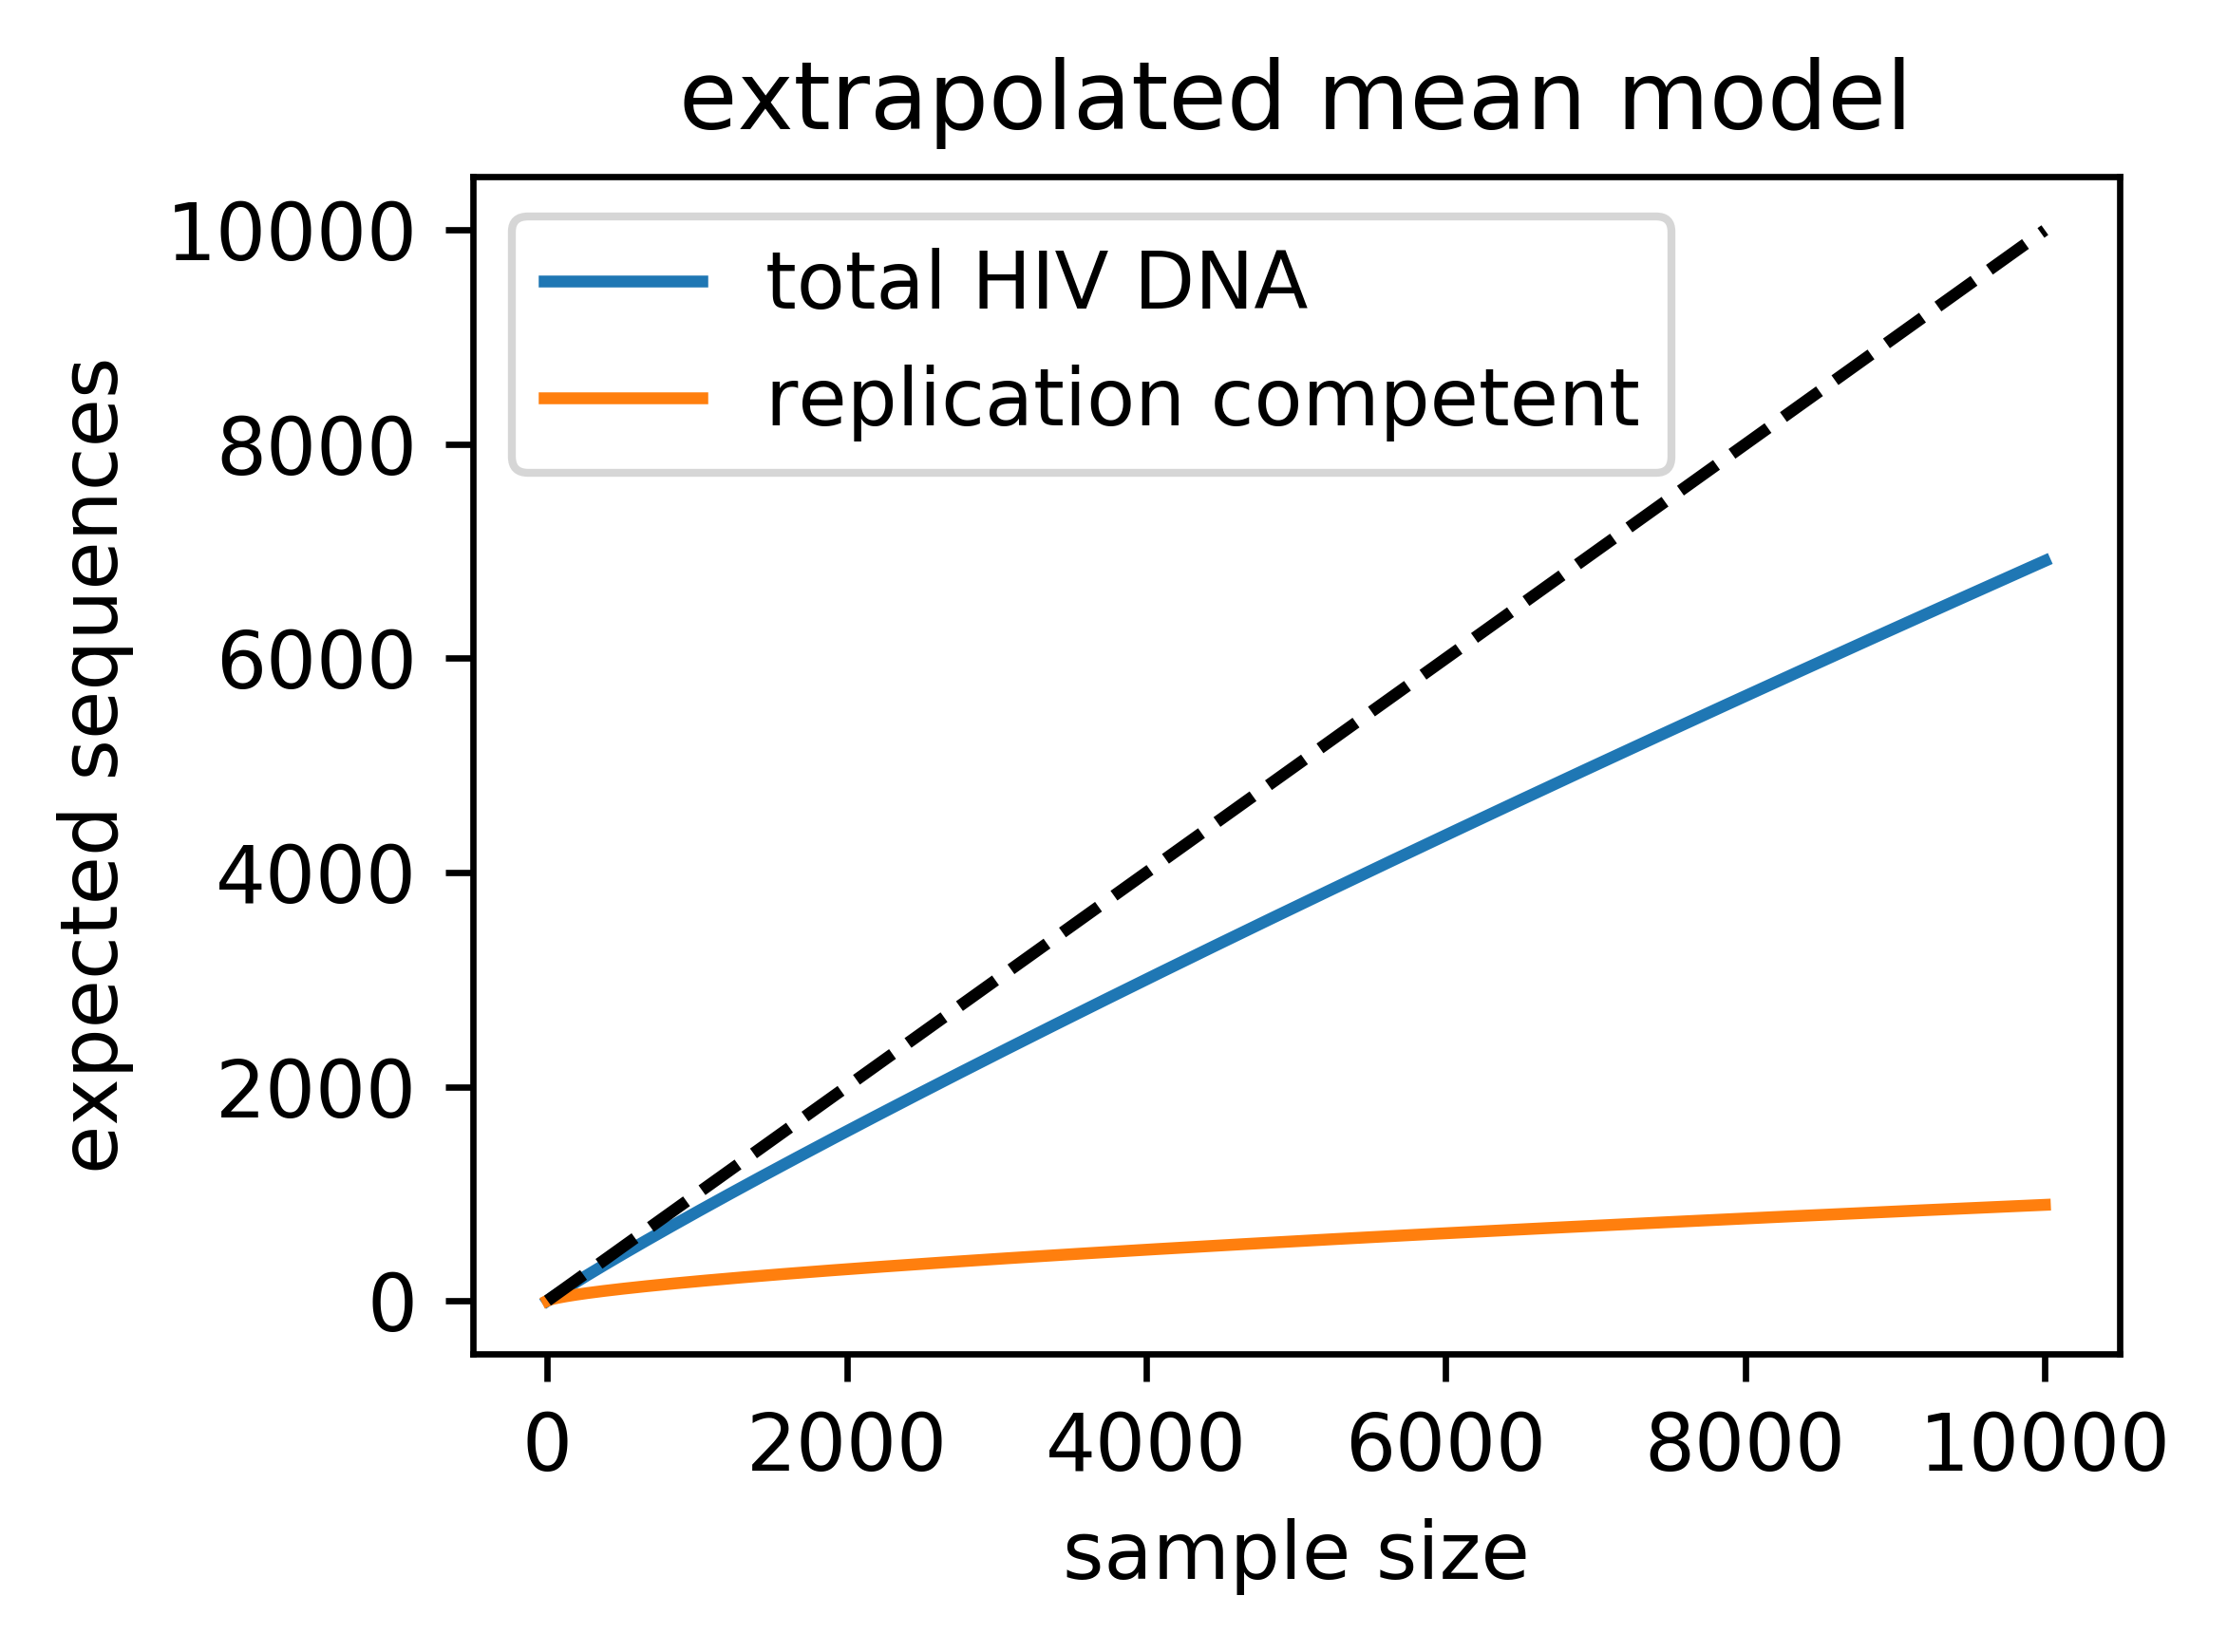

In [84]:
plt.figure(figsize=(4,3),dpi=600)
plt.plot(cD,fD)
plt.plot(cH,fH)
plt.plot(cH,cH,'--',color='k')
plt.xlabel('sample size')
plt.ylabel('expected sequences')
plt.legend(['total HIV DNA','replication competent'],fontsize=10)
plt.title('extrapolated mean model')
plt.tight_layout()
plt.savefig('figures/rarefaction_extrapolated.pdf')   